Setup

In [1]:
import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Upload data files

In [2]:
from google.colab import files
uploaded = files.upload()

CLUSTER_NAMES = ["C1_low","C2_lower_mid","C3_mid","C4_upper_mid","C5_high","C6_top5"]
MONTHS_PER_PERSON = 48

def cluster_from_filename(fname: str) -> str:
    return os.path.basename(fname).replace(".csv", "")

def load_one_csv(path, months_per_person=48, max_people=None):
    cluster_label = cluster_from_filename(path)

    nrows = None
    if max_people is not None:
        nrows = int(max_people) * int(months_per_person)

    df = pd.read_csv(path, nrows=nrows)

    m = re.match(r"^(C\d)", cluster_label)
    cluster_idx = int(m.group(1)[1:]) - 1 if m else CLUSTER_NAMES.index(cluster_label)

    if {"person_id","month_index"}.issubset(df.columns):
        df["person_id"] = df["person_id"].astype(np.int64)
        df["month_index"] = df["month_index"].astype(np.int16)
    else:
        ridx = np.arange(len(df), dtype=np.int64)
        df["month_index"] = (ridx % months_per_person).astype(np.int16)
        df["person_id"]  = (ridx // months_per_person).astype(np.int32)

    df["person_id"] = df["person_id"].astype(np.int64) + cluster_idx * 10_000_000
    df["cluster"] = cluster_label
    df["cluster_index"] = cluster_idx

    return df

paths = sorted([f"/content/{k}" for k in uploaded.keys() if k.lower().endswith(".csv")])
dfs = [load_one_csv(p, MONTHS_PER_PERSON, max_people=None) for p in paths]
df_monthly = pd.concat(dfs, ignore_index=True)

print(df_monthly.shape)
print(df_monthly["cluster"].value_counts())
df_monthly.head()

Saving C1_low.csv to C1_low.csv
Saving C2_lower_mid.csv to C2_lower_mid.csv
Saving C3_mid.csv to C3_mid.csv
Saving C4_upper_mid.csv to C4_upper_mid.csv
Saving C5_high.csv to C5_high.csv
Saving C6_top5.csv to C6_top5.csv
(5760000, 21)
cluster
C1_low          960000
C2_lower_mid    960000
C3_mid          960000
C4_upper_mid    960000
C5_high         960000
C6_top5         960000
Name: count, dtype: int64


cluster  person_id  month_index  Income_Deposits  Housing  \
0  C1_low          0            0          1108.67    400.0   
1  C1_low          0            1          1117.28    400.0   
2  C1_low          0            2          1106.12    400.0   
3  C1_low          0            3          1106.95    400.0   
4  C1_low          0            4          1131.74    400.0   

   Utilities_Telecom  Groceries_FoodAtHome  Dining_FoodAway  \
0             104.26                 250.0             7.33   
1              80.00                 250.0            18.77   
2              80.00                 250.0             1.43   
3              80.00                 250.0             1.62   
4              80.00                 250.0             0.00   

   Transportation_Variable  Auto_Costs  ...  Insurance_All  Debt_Payments  \
0                    71.47        4.73  ...          50.00         122.34   
1                    88.77        8.75  ...          51.85          81.80   
2                    68.24        1.65  ...          50.00           9.26   
3                    66.42        1.75  ...          51.09           3.52   
4                    67.90        0.00  ...          50.00           0.00   

   Savings_Investments  Education_Childcare  Entertainment  \
0                 5.51                25.77           9.92   
1                 5.18                 4.83           2.41   
2                 0.06                 0.11           0.31   
3                 0.61                 0.95           1.79   
4                 0.00                 0.00           0.00   

   Subscriptions_Memberships  Cash_ATM_MiscTransfers   Pets  Travel  \
0                      19.96                   49.87  19.64    0.20   
1                      12.74                   14.03   6.65    0.04   
2                       0.51                    0.63   2.44    0.03   
3                       0.21                    2.54   0.13    0.12   
4                       0.00                    0.00   0.00    0.00   

   cluster_index  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 21 columns]

Helper functions (plots, splits, quick eval, state)

In [3]:
!pip -q install tqdm imbalanced-learn statsmodels xgboost

In [4]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import xgboost as xgb

# keep all decisions here so every next cell uses the best one
STATE = {}

# use it if you want faster runs while iterating. set False when you go final.
FAST_MODE = True
PEOPLE_CAP_FAST = 40000  # how many people rows to use for heavy compare steps (feature selection, etc)

def plot_hist_overlay(df, cols, title, bins=60, n=50000):
    # usual plot style: overlay before/after hist
    sample = df.sample(n=min(n, len(df)), random_state=RANDOM_SEED) if len(df) > n else df
    plt.figure(figsize=(14, 6))
    for c in cols:
        if c in sample.columns:
            plt.hist(sample[c].values, bins=bins, alpha=0.45, label=c)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_box(df, cols, title, n=50000):
    sample = df.sample(n=min(n, len(df)), random_state=RANDOM_SEED) if len(df) > n else df
    cols2 = [c for c in cols if c in sample.columns]
    plt.figure(figsize=(14, 5))
    plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)
    plt.title(title)
    plt.xticks(rotation=25, ha="right")
    plt.show()

def split_by_group(X_df, y, groups, test_size=0.2):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=RANDOM_SEED)
    tr_idx, te_idx = next(gss.split(X_df, y, groups=groups))
    return tr_idx, te_idx

def quick_eval_lr(X_df, y, groups, scaler_name="standard", penalty_mode="l2", C=1.0, l1_ratio=0.5):
    # fast evaluation model. its not for final accuracy, its for comparing pipeline choices
    tr_idx, te_idx = split_by_group(X_df, y, groups)
    Xtr = X_df.iloc[tr_idx].values
    Xte = X_df.iloc[te_idx].values
    ytr = y[tr_idx]
    yte = y[te_idx]

    scaler = None
    if scaler_name == "standard":
        scaler = StandardScaler()
    elif scaler_name == "robust":
        scaler = RobustScaler()
    elif scaler_name == "minmax":
        scaler = MinMaxScaler()

    if scaler is not None:
        scaler.fit(Xtr)
        Xtr = scaler.transform(Xtr)
        Xte = scaler.transform(Xte)

    # regularization choices here, more detailed later
    if penalty_mode == "elasticnet":
        lr = LogisticRegression(
            multi_class="multinomial",
            solver="saga",
            penalty="elasticnet",
            l1_ratio=l1_ratio,
            C=C,
            max_iter=800,
            n_jobs=-1,
            random_state=RANDOM_SEED
        )
    elif penalty_mode == "l1":
        lr = LogisticRegression(
            multi_class="multinomial",
            solver="saga",
            penalty="l1",
            C=C,
            max_iter=800,
            n_jobs=-1,
            random_state=RANDOM_SEED
        )
    else:
        lr = LogisticRegression(
            multi_class="multinomial",
            solver="lbfgs",
            penalty=None,   # lbfgs does l2-style by default for multinomial; penalty=None works for newer sklearn
            max_iter=600,
            n_jobs=-1
        )
        # if your sklearn complains about penalty=None, swap to:
        # lr = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=C, max_iter=600, n_jobs=-1)

    lr.fit(Xtr, ytr)
    pred = lr.predict(Xte)

    acc = accuracy_score(yte, pred)
    mf1 = f1_score(yte, pred, average="macro")
    return acc, mf1

Data Cleaning with before/after plots and quality metrics

rows before: 5760000
missing before: 0
negatives before: 0


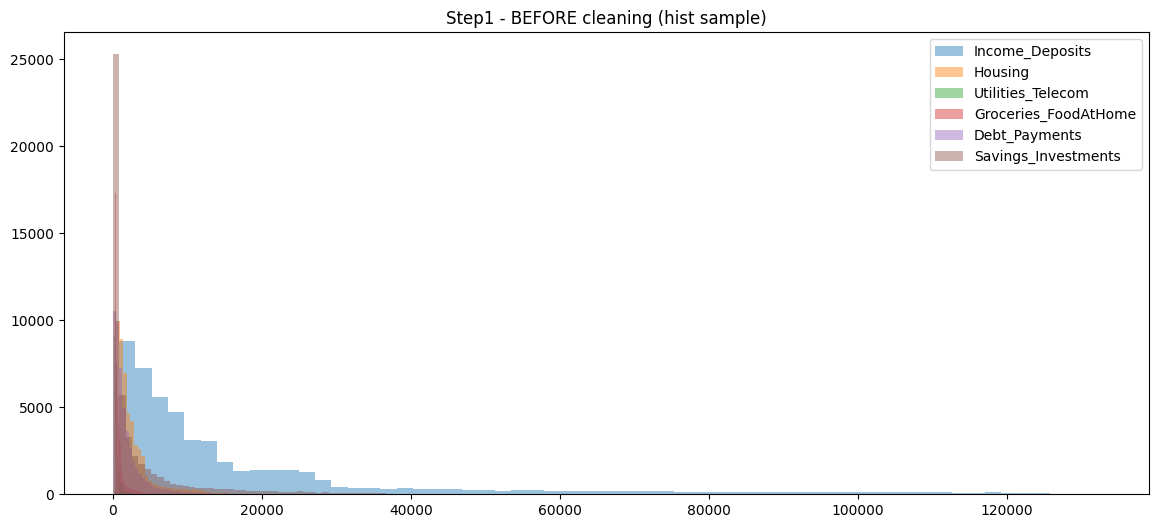

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


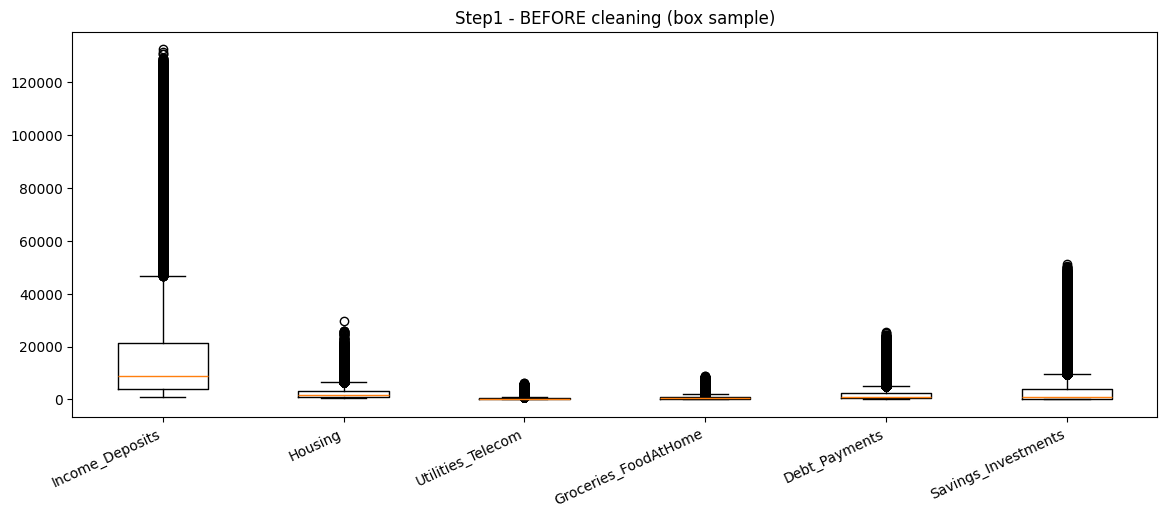


rows after: 5760000
missing after: 0
negatives after: 0


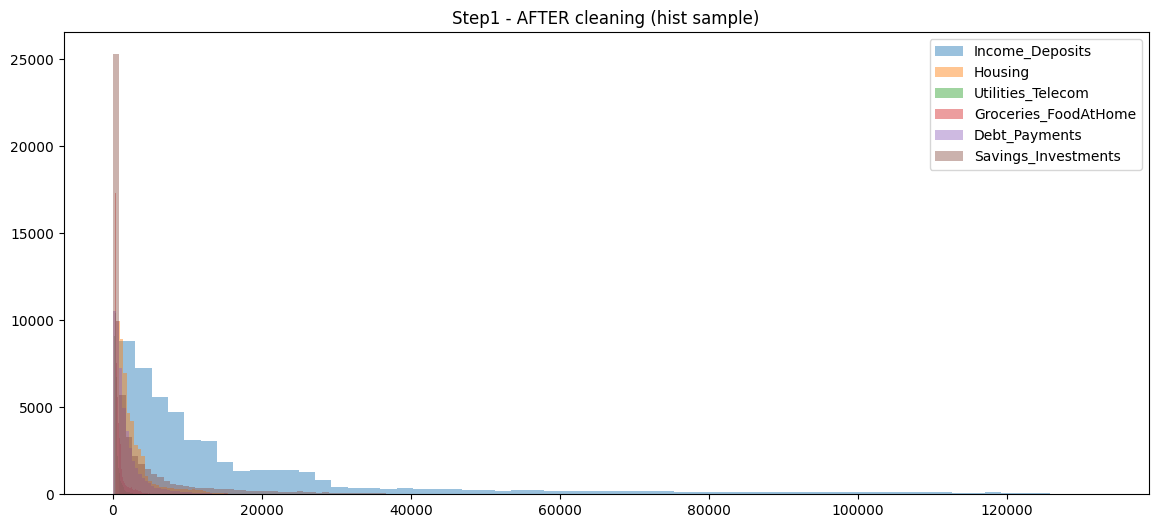

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


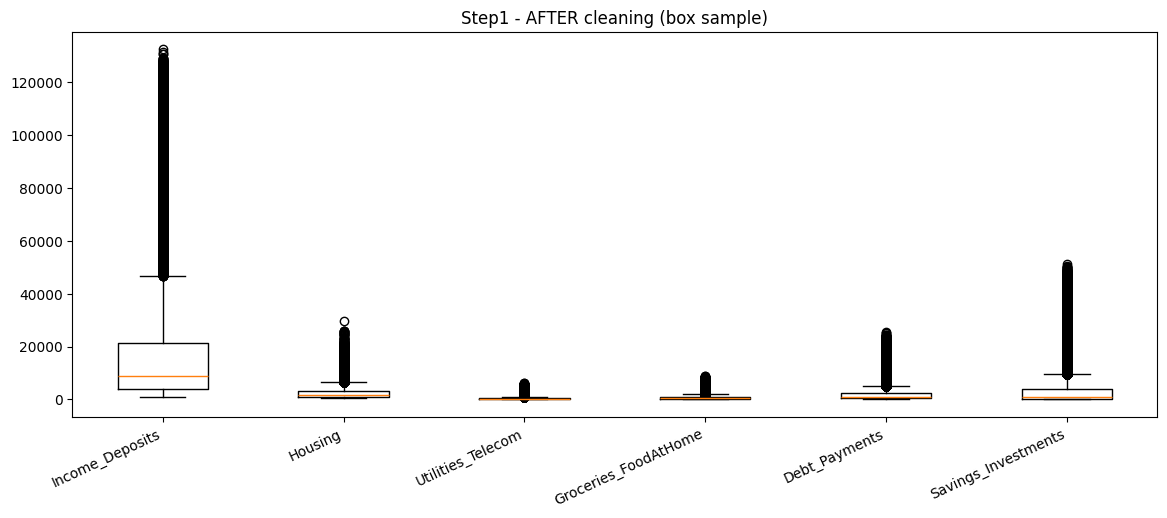


Step1 done. saved as STATE['df_clean_monthly']


In [5]:
df0 = df_monthly.copy()

META = {"cluster","cluster_index","person_id","month_index"}
if "Income_Deposits" not in df0.columns:
    raise ValueError("Income_Deposits is missing, check your csv column name")

INCOME_COL = "Income_Deposits"
money_cols = [c for c in df0.columns if c not in META]
outflow_cols = [c for c in money_cols if c != INCOME_COL]

# pick some columns for plots (only if they exist)
plot_candidates = [INCOME_COL, "Housing", "Utilities_Telecom", "Groceries_FoodAtHome", "Debt_Payments", "Savings_Investments", "Travel"]
plot_cols = [c for c in plot_candidates if c in df0.columns]

print("rows before:", len(df0))
print("missing before:", int(df0.isna().sum().sum()))
print("negatives before:", int((df0[outflow_cols] < 0).sum().sum()) if len(outflow_cols) else 0)

# plots BEFORE
plot_hist_overlay(df0, plot_cols[:6], "Step1 - BEFORE cleaning (hist sample)")
plot_box(df0, plot_cols[:6], "Step1 - BEFORE cleaning (box sample)")

# cleaning rules
df1 = df0.replace([np.inf, -np.inf], np.nan).dropna()

df1 = df1[df1[INCOME_COL] > 0]

# no negative spending
for c in outflow_cols:
    df1[c] = df1[c].clip(lower=0.0)

# essentials average-case (skip if column doesnt exist)
essentials = [c for c in ["Housing","Utilities_Telecom","Groceries_FoodAtHome"] if c in df1.columns]
for c in essentials:
    df1 = df1[df1[c] > 0]

# add totals + cashflow for later
df1["TotalOutflow"] = df1[outflow_cols].sum(axis=1).astype(np.float32)
df1["NetCashflow"] = (df1[INCOME_COL] - df1["TotalOutflow"]).astype(np.float32)
df1["NetCashflowRate"] = (df1["NetCashflow"] / df1[INCOME_COL]).astype(np.float32)

print("\nrows after:", len(df1))
print("missing after:", int(df1.isna().sum().sum()))
print("negatives after:", int((df1[outflow_cols] < 0).sum().sum()) if len(outflow_cols) else 0)

# plots AFTER
plot_hist_overlay(df1, plot_cols[:6], "Step1 - AFTER cleaning (hist sample)")
plot_box(df1, plot_cols[:6], "Step1 - AFTER cleaning (box sample)")

STATE["df_clean_monthly"] = df1
print("\nStep1 done. saved as STATE['df_clean_monthly']")

Feature Encoding (shares + rates) with person-level table and baseline eval

In [6]:
# important: do NOT use income as an input feature, but use it to compute shares.
# also move to person-level dataset to avoid leakage and reduce compute.

dfm = STATE["df_clean_monthly"].copy()

# define feature money cols again
money_cols = [c for c in dfm.columns if c not in META]
outflow_cols = [c for c in money_cols if c not in (INCOME_COL, "TotalOutflow", "NetCashflow", "NetCashflowRate")]

# create share features for each outflow
for c in outflow_cols:
    dfm[f"{c}__share"] = (dfm[c] / dfm[INCOME_COL]).astype(np.float32)

# summary rates (only if columns exist)
def safe_sum(cols):
    cols2 = [c for c in cols if c in dfm.columns]
    if not cols2:
        return 0.0
    return dfm[cols2].sum(axis=1)

dfm["EssentialRate"] = (safe_sum(["Housing","Utilities_Telecom","Groceries_FoodAtHome"]) / dfm[INCOME_COL]).astype(np.float32)
dfm["DebtRate"] = (dfm["Debt_Payments"] / dfm[INCOME_COL]).astype(np.float32) if "Debt_Payments" in dfm.columns else 0.0
dfm["SavingsRate"] = (dfm["Savings_Investments"] / dfm[INCOME_COL]).astype(np.float32) if "Savings_Investments" in dfm.columns else 0.0
dfm["DiscretionaryRate"] = (safe_sum(["Dining_FoodAway","Entertainment","Travel","Subscriptions_Memberships"]) / dfm[INCOME_COL]).astype(np.float32)
# NetCashflowRate already exists from cleaning

share_cols = [c for c in dfm.columns if c.endswith("__share")]
rate_cols = ["EssentialRate","DebtRate","SavingsRate","DiscretionaryRate","NetCashflowRate"]
rate_cols = [c for c in rate_cols if c in dfm.columns]

# now person-level: mean/median/std over 48 months
g = dfm.groupby("person_id", sort=False)

agg = g[share_cols + rate_cols].agg(["mean","median","std"]).reset_index()
agg.columns = ["person_id"] + [f"{c}__{stat}" for c, stat in agg.columns[1:]]

labels = g[["cluster_index","cluster"]].first().reset_index()

df_people = labels.merge(agg, on="person_id", how="inner")

# fast cap
if FAST_MODE and len(df_people) > PEOPLE_CAP_FAST:
    df_people = df_people.sample(n=PEOPLE_CAP_FAST, random_state=RANDOM_SEED)

print("people rows:", df_people.shape)
print(df_people["cluster"].value_counts())

X_base = df_people.drop(columns=["cluster","cluster_index","person_id"])
y_base = df_people["cluster_index"].astype(int).values
groups = df_people["person_id"].astype(np.int64).values

# baseline evaluation
acc0, f10 = quick_eval_lr(X_base, y_base, groups, scaler_name="standard", penalty_mode="l2")
print(f"\nStep2 baseline eval (LR): acc={acc0:.4f} macro_f1={f10:.4f}")

STATE["df_people"] = df_people
STATE["X_current"] = X_base
STATE["y"] = y_base
STATE["groups"] = groups
STATE["feature_cols"] = list(X_base.columns)
print("\nStep2 done. saved df_people + X_current")

people rows: (40000, 66)
cluster
C3_mid          6792
C2_lower_mid    6720
C4_upper_mid    6679
C5_high         6634
C1_low          6623
C6_top5         6552
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step2 baseline eval (LR): acc=0.9989 macro_f1=0.9989

Step2 done. saved df_people + X_current


Data Normalization (square, inverse, log, z-score, and more) with before/after plots, eval, and pick best

Step3 normalization compare:   0%|          | 0/9 [00:00<?, ?it/s]

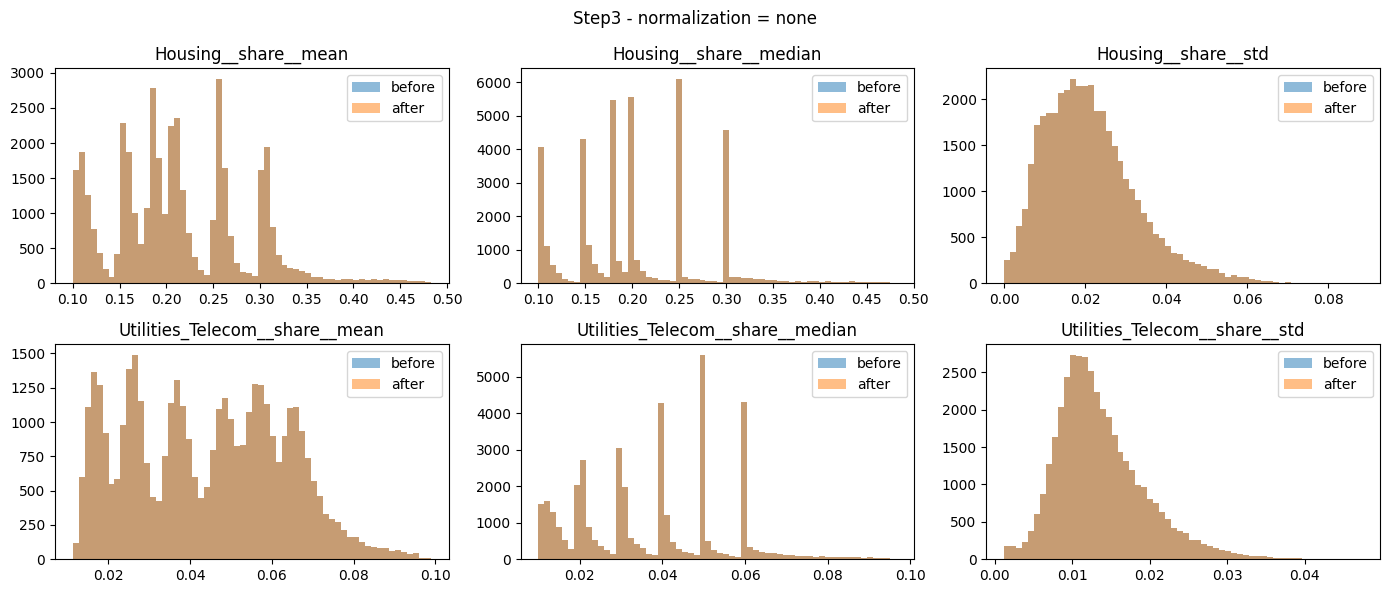

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


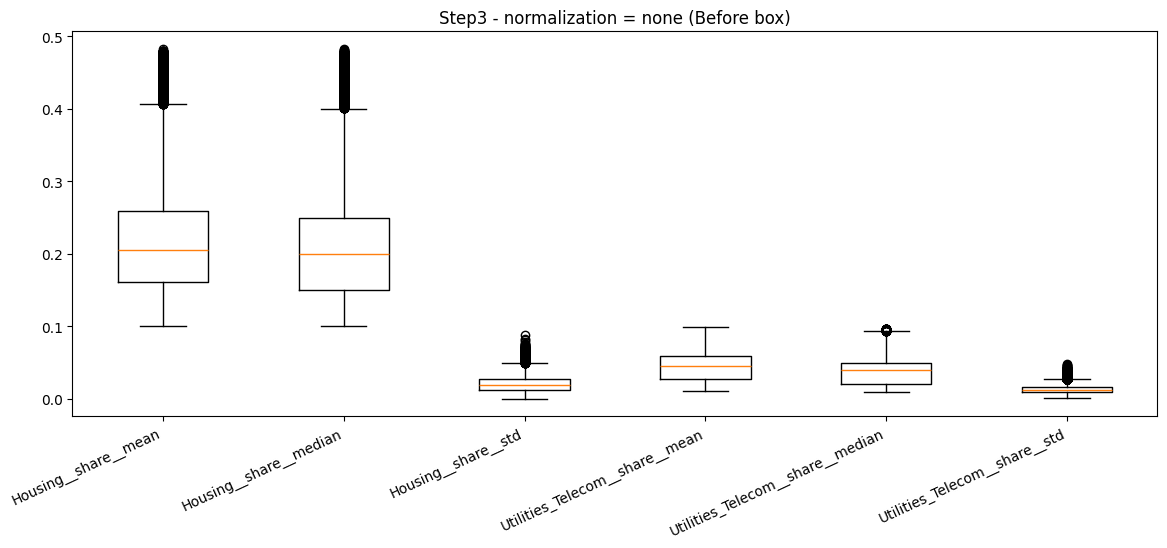

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


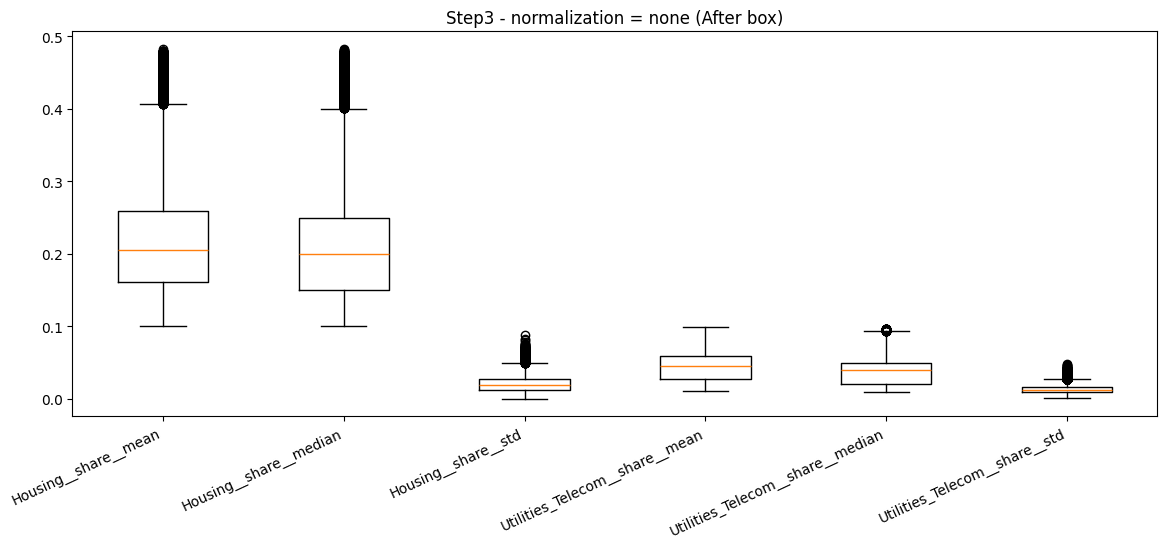

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


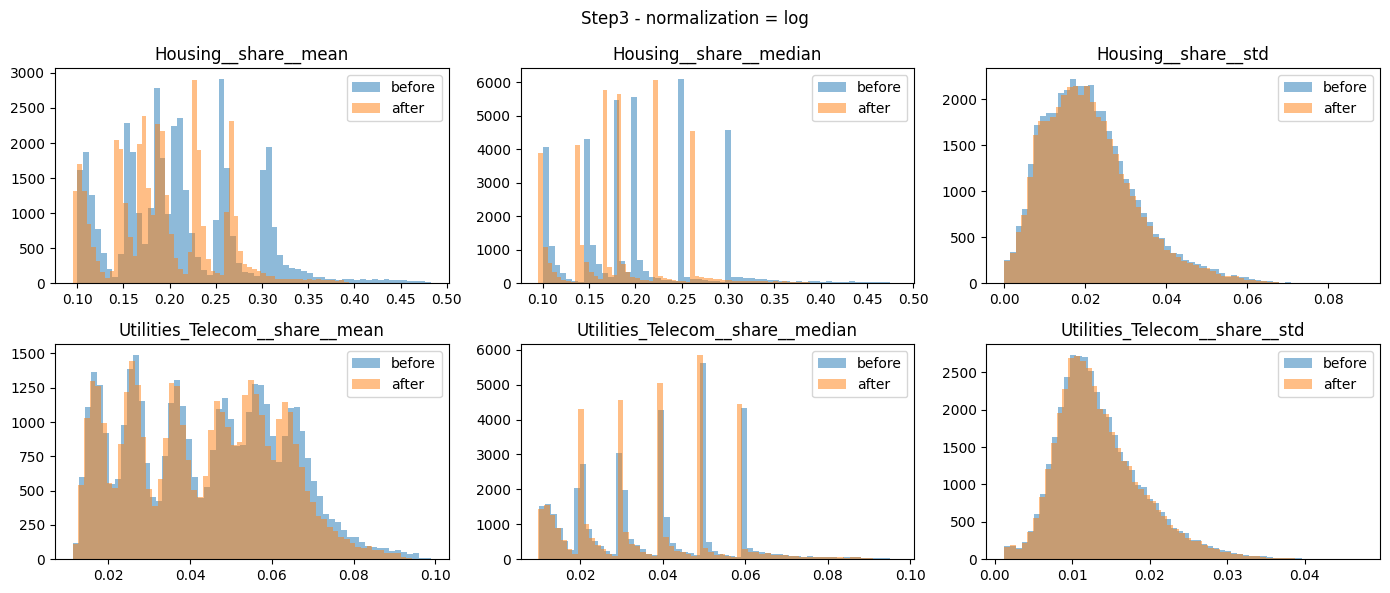

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


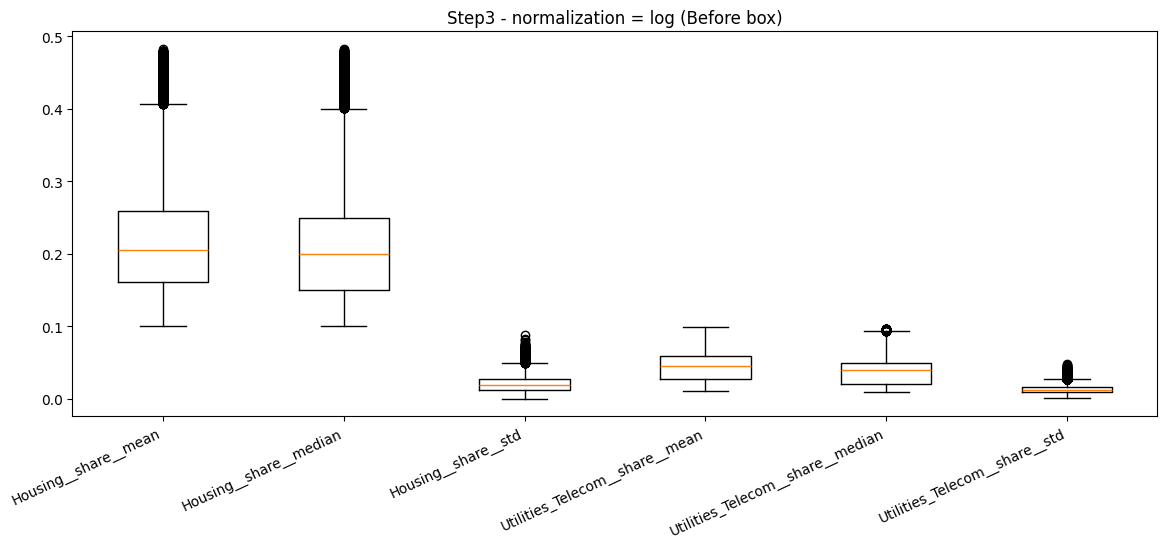

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


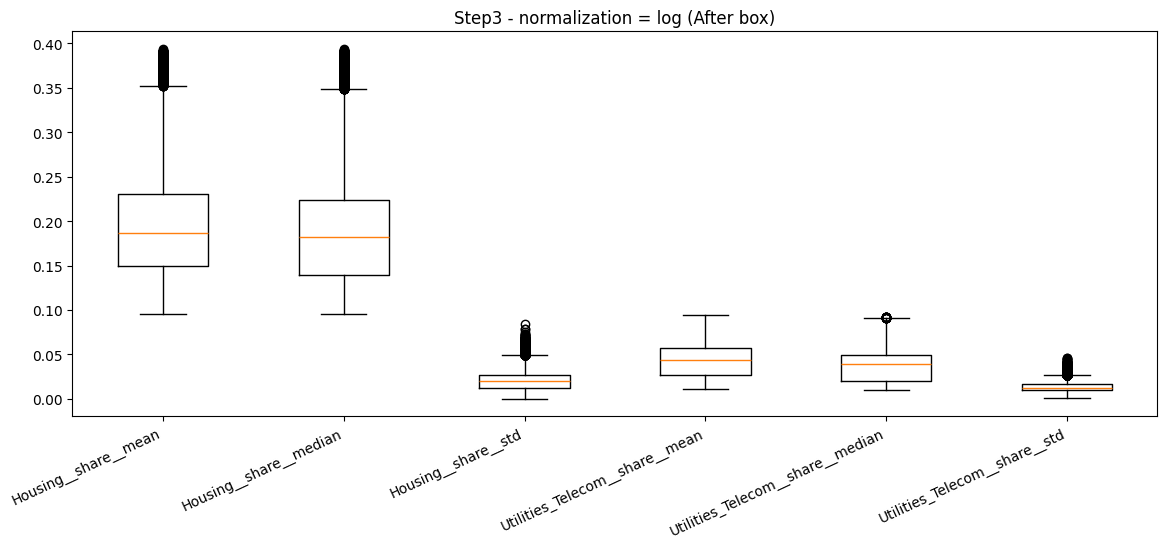

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


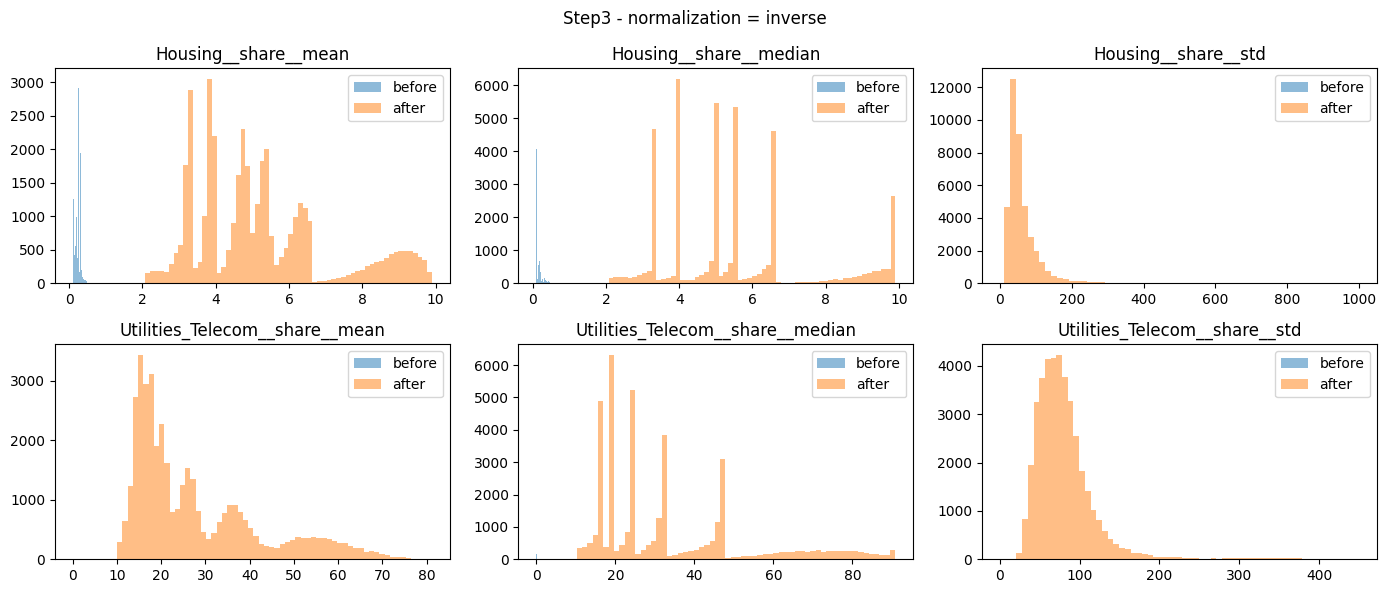

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


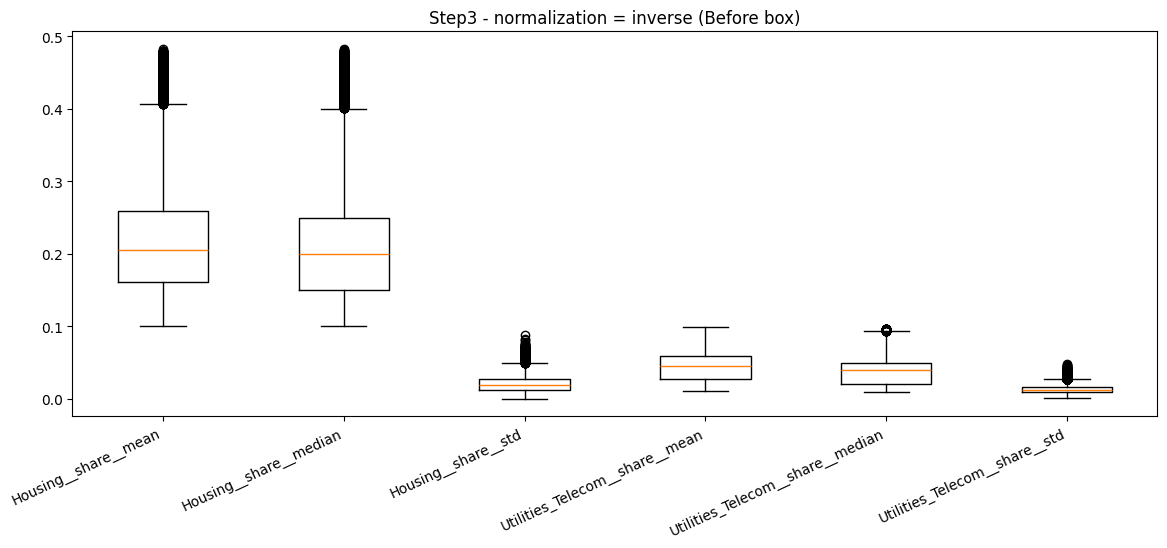

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


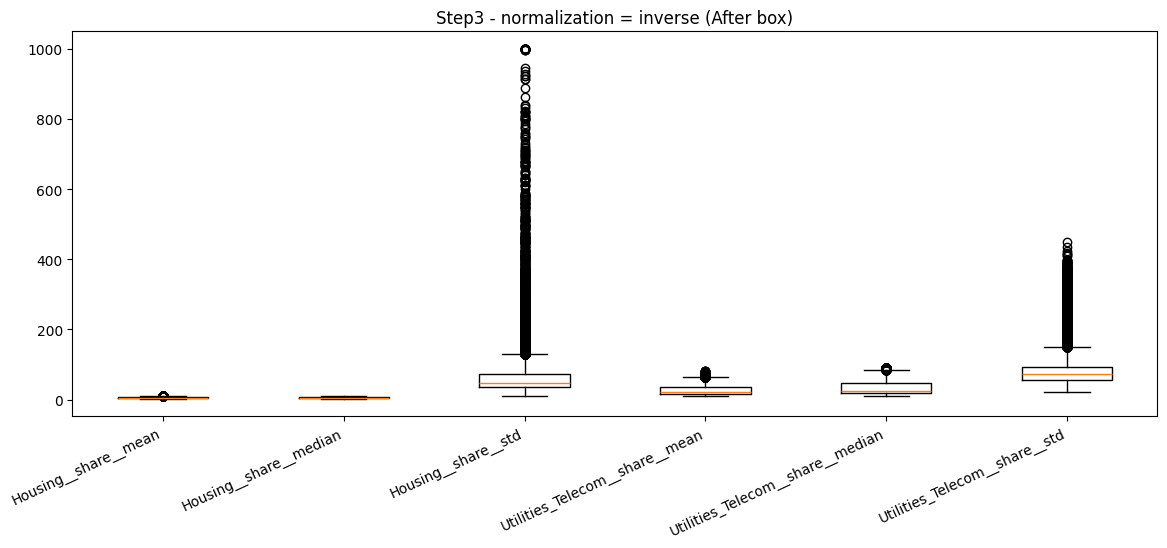

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


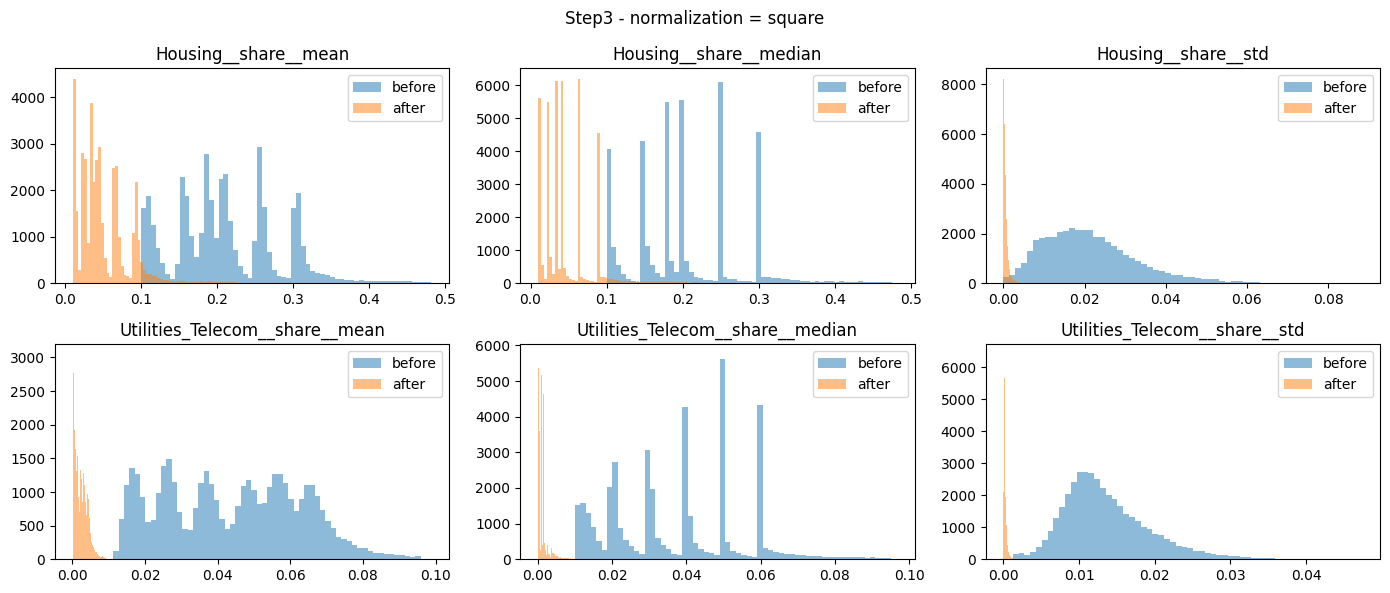

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


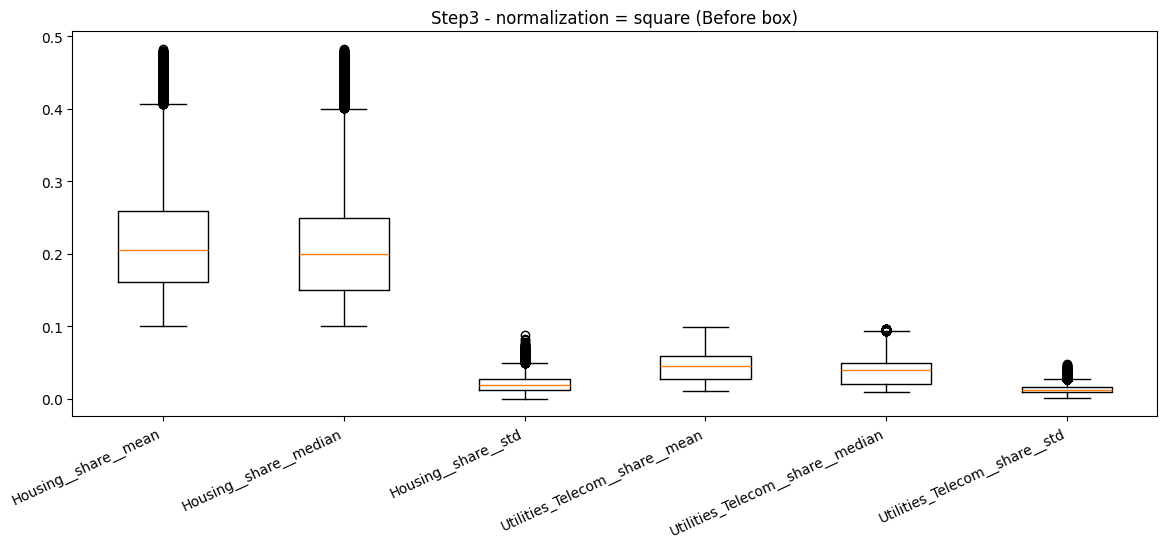

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


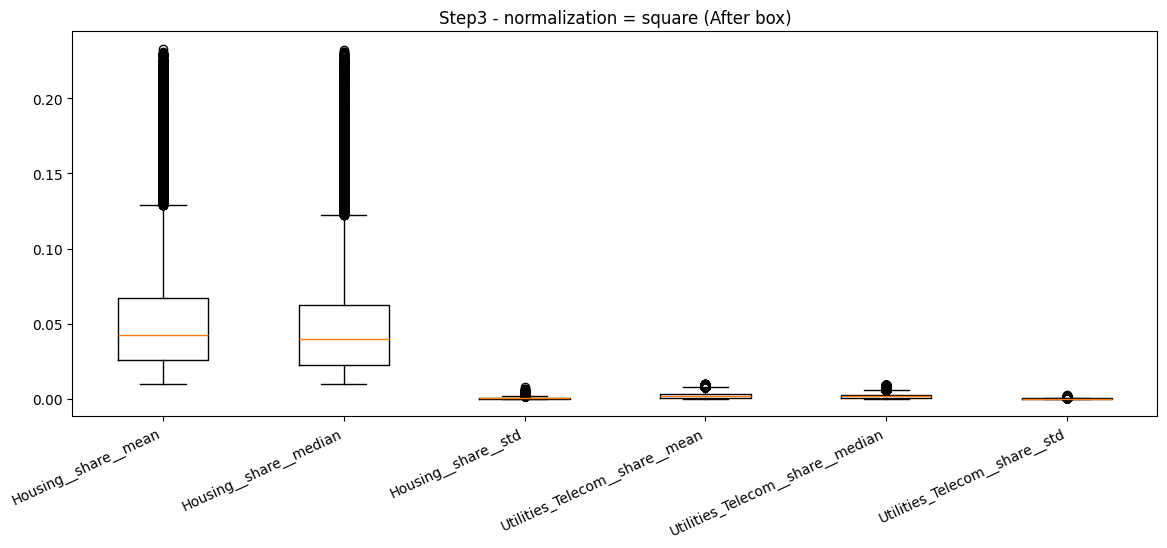

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


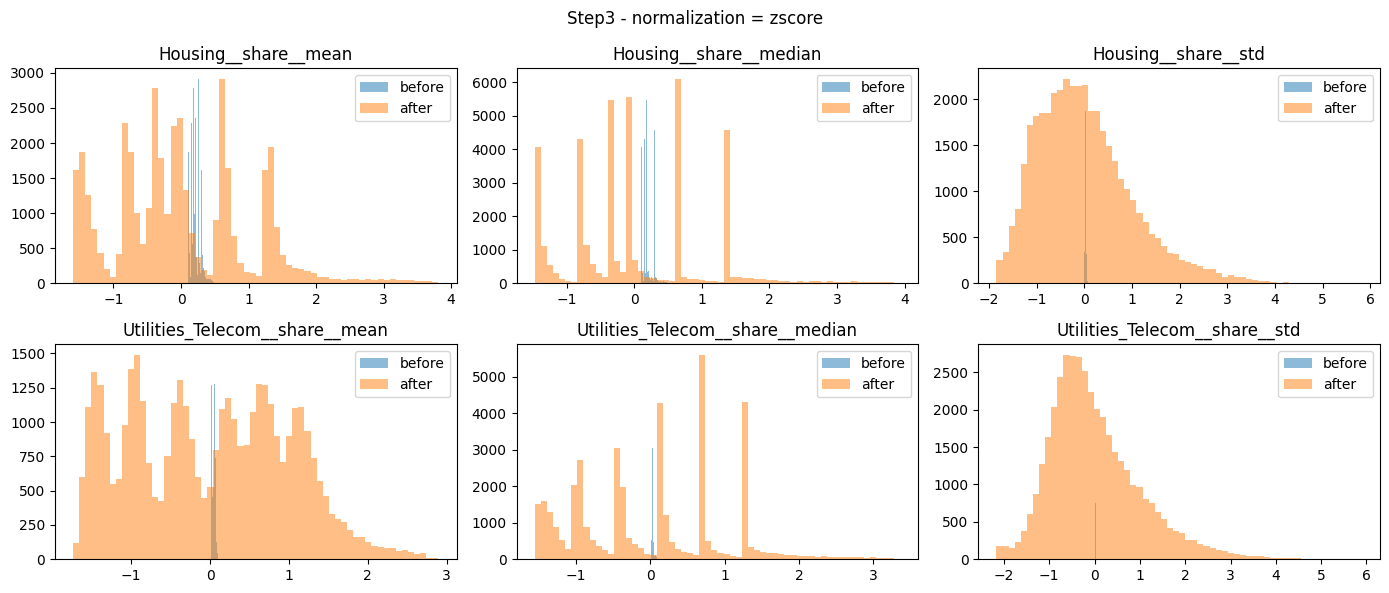

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


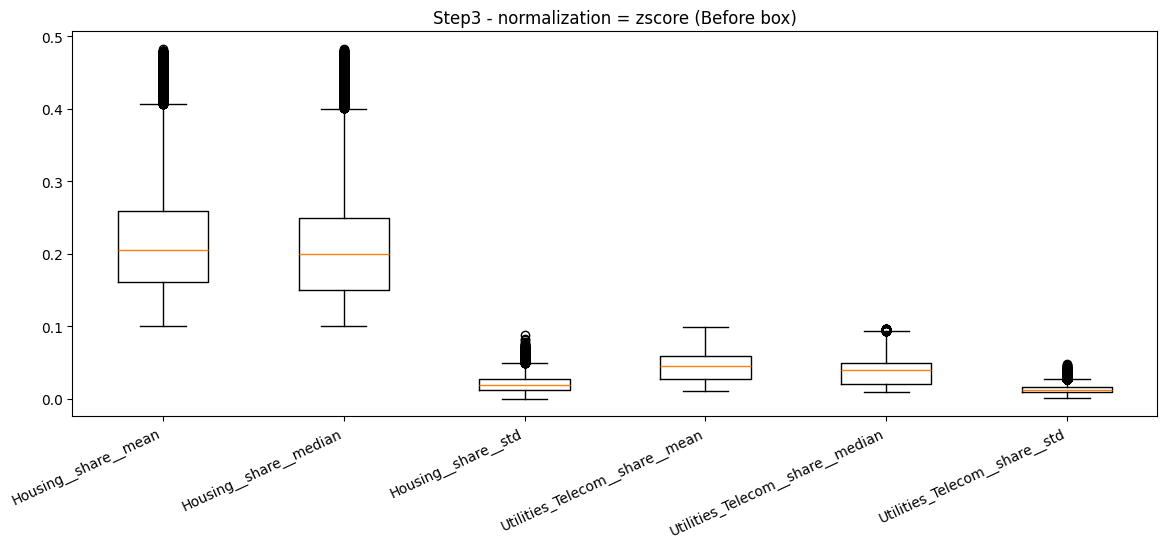

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


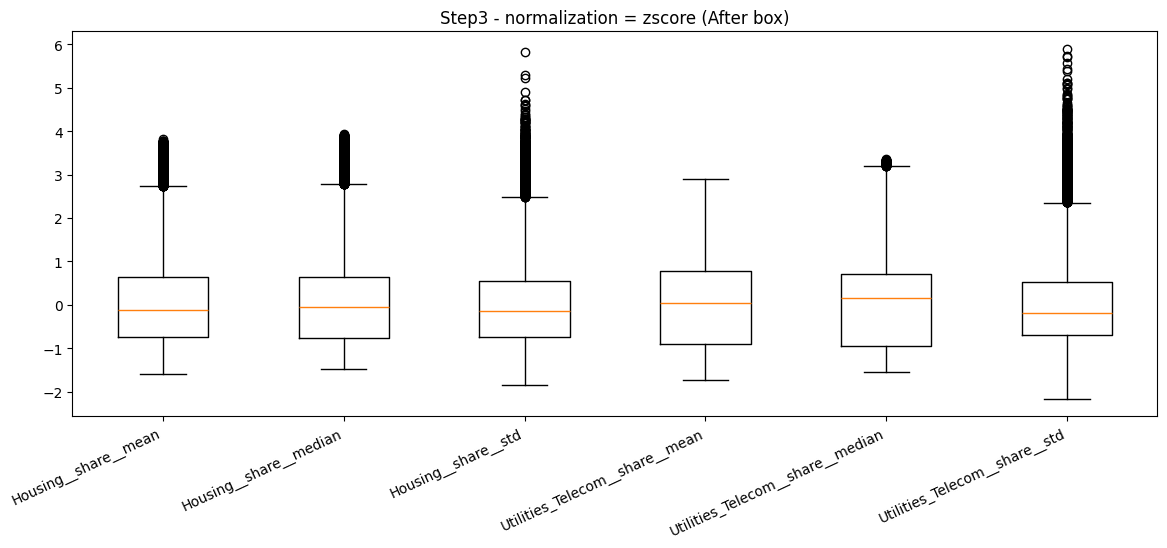

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


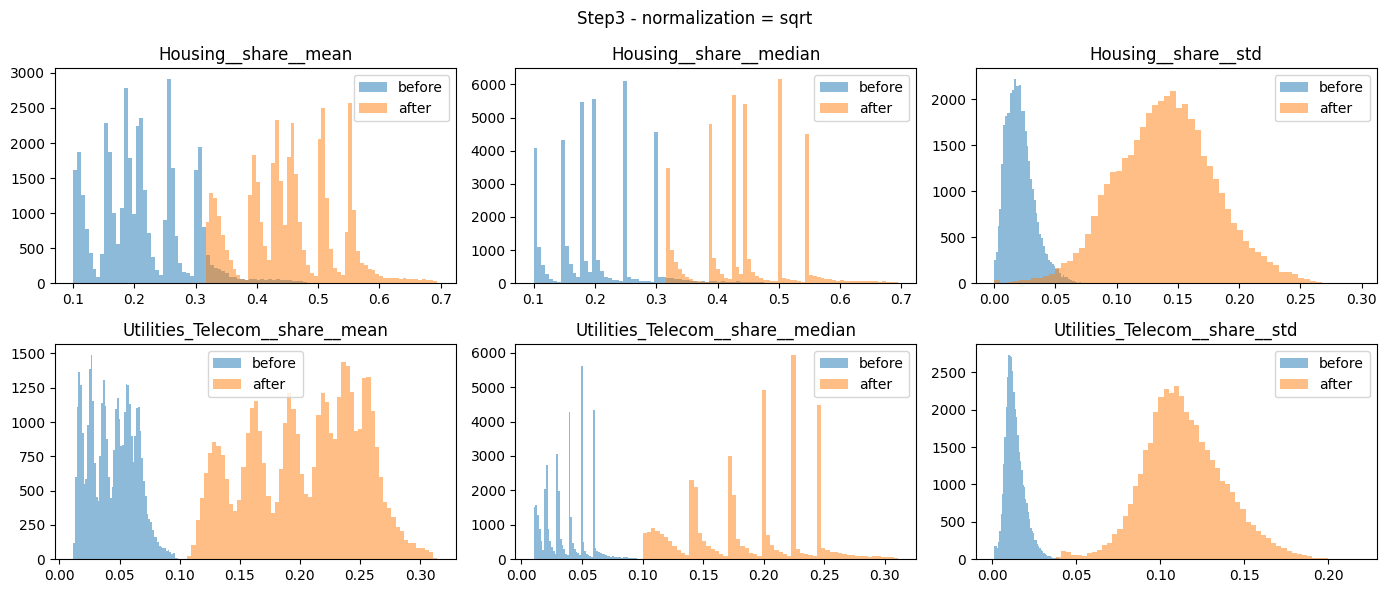

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


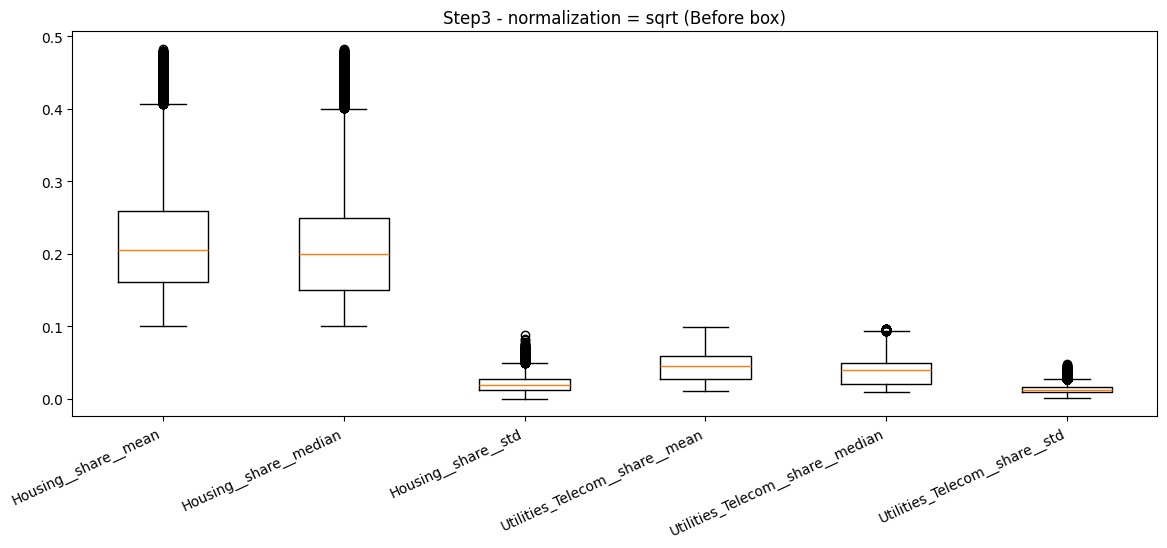

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


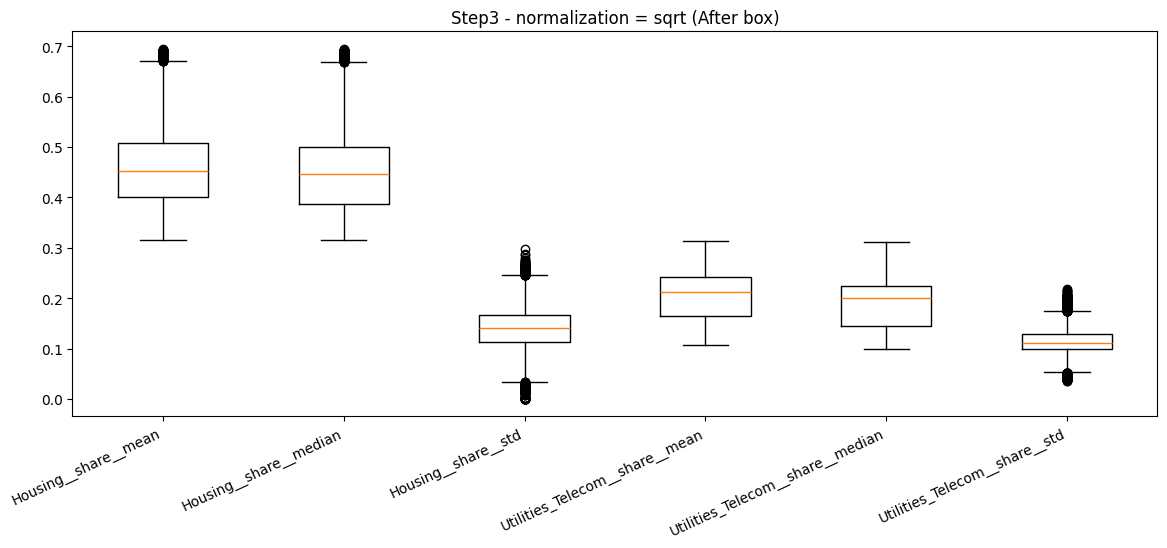

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


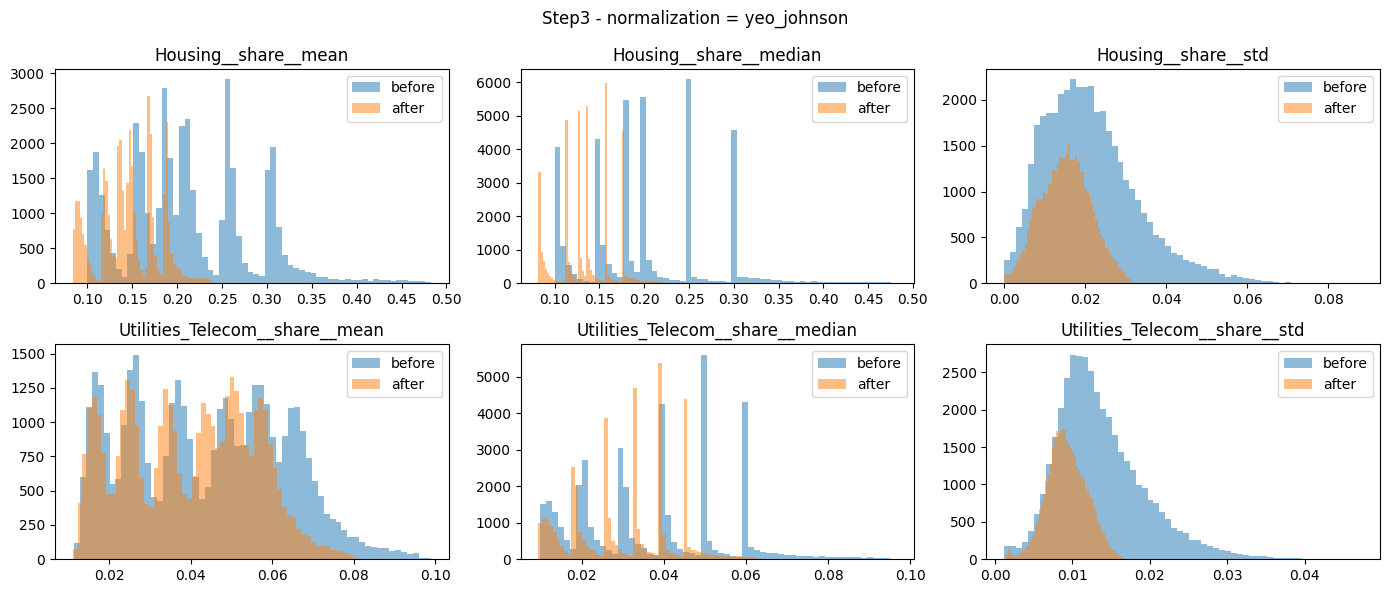

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


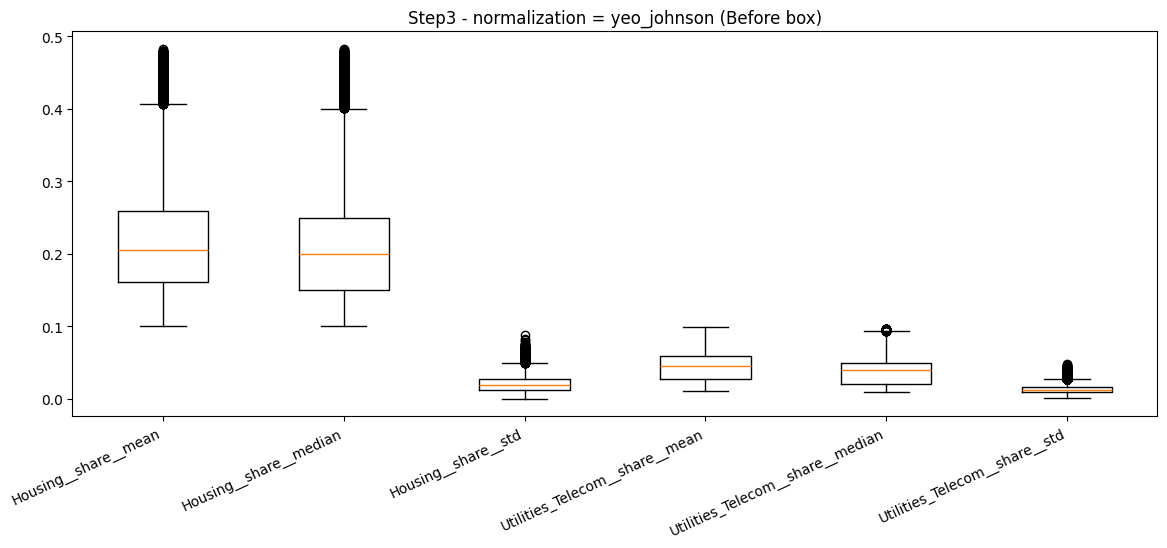

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


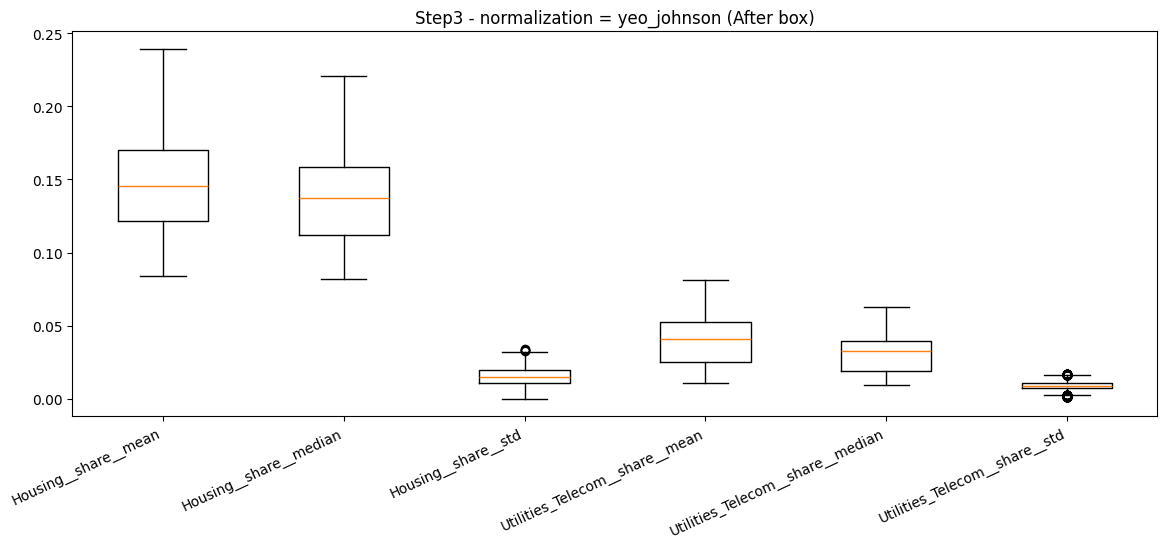

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


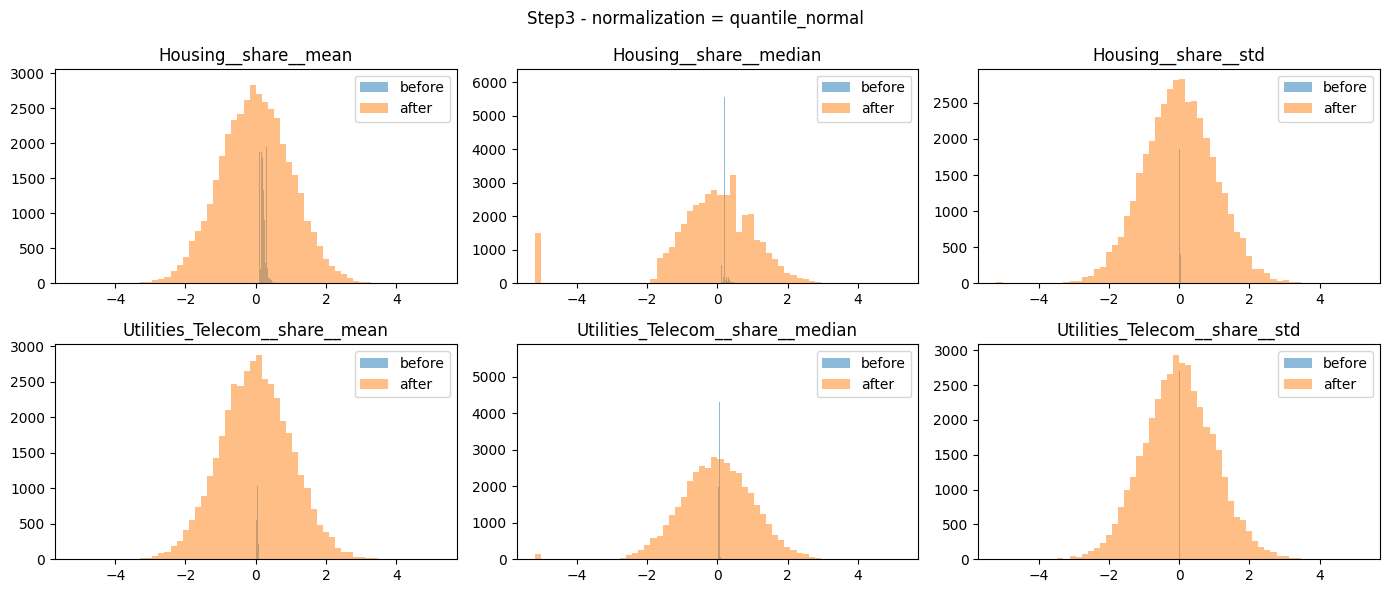

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


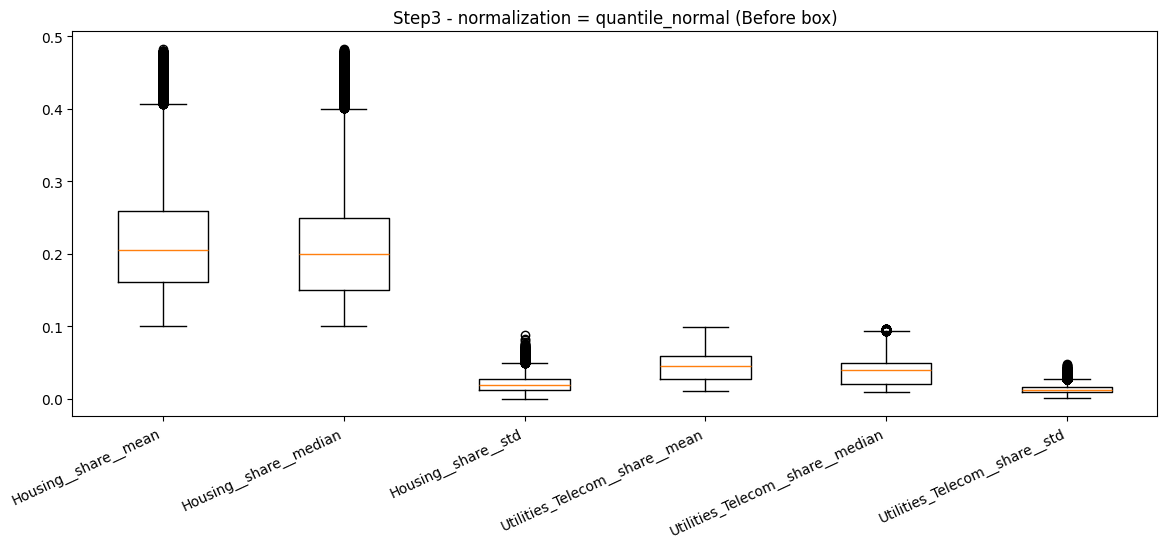

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


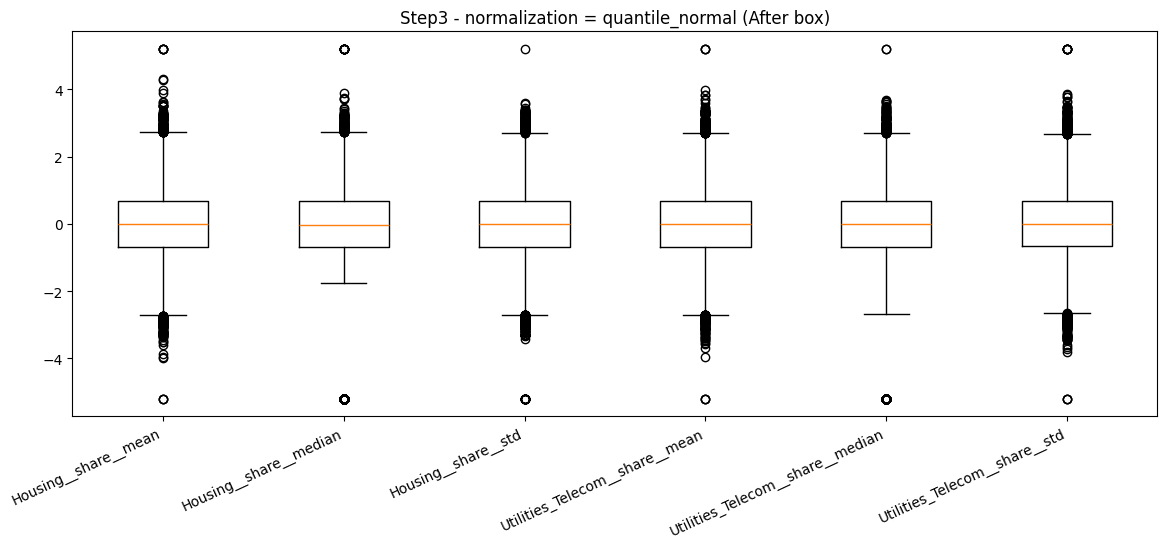

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


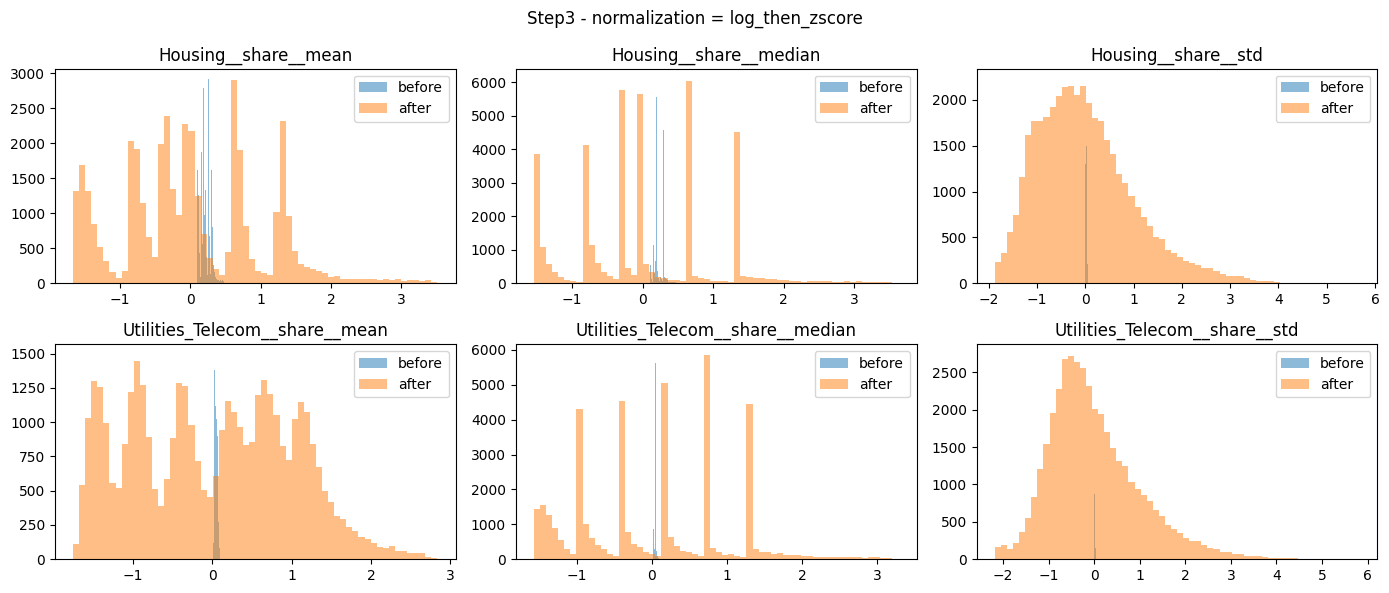

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


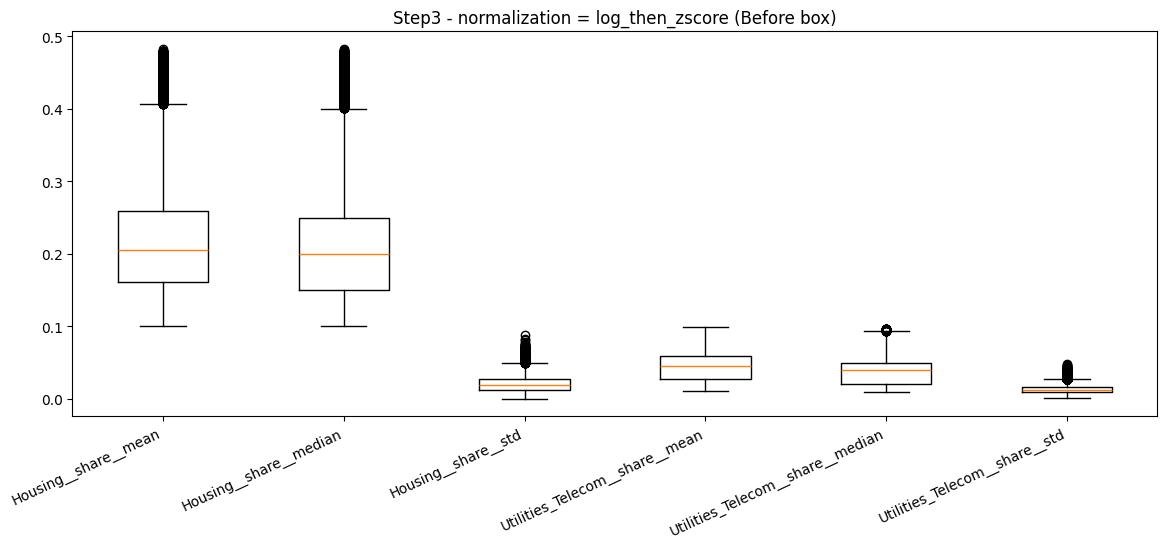

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


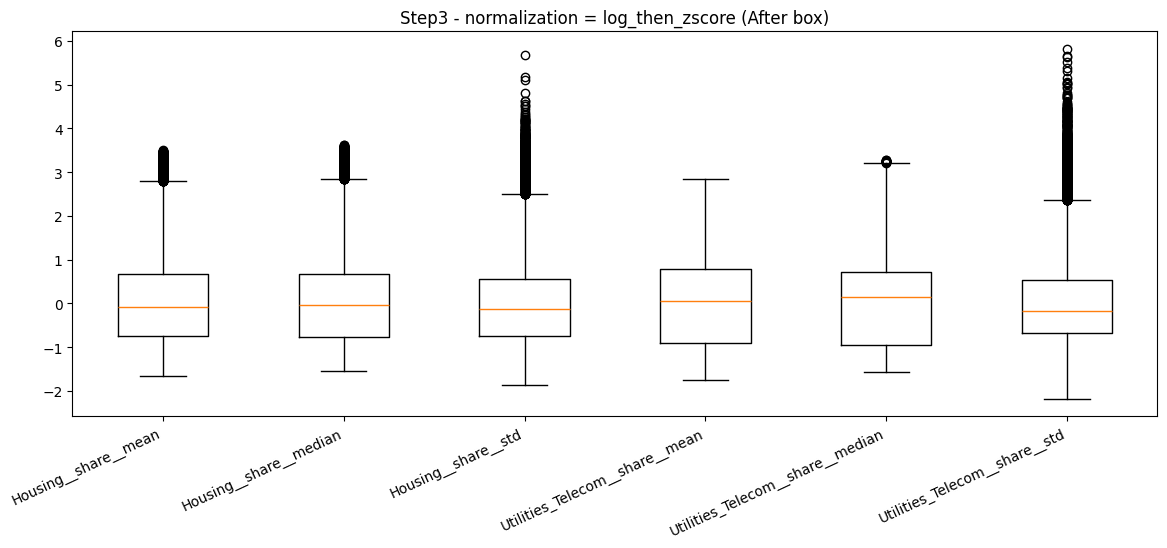

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step3 summary:


method       acc  macro_f1
7  quantile_normal  0.999250  0.999250
8  log_then_zscore  0.999000  0.998996
1              log  0.999000  0.998996
0             none  0.998875  0.998872
4           zscore  0.998875  0.998872
3           square  0.998625  0.998622
5             sqrt  0.998250  0.998247
2          inverse  0.998125  0.998123
6      yeo_johnson  0.997875  0.997873


Step3 BEST = quantile_normal | acc=0.9992 macro_f1=0.9992


In [7]:
# compare methods, plot before/after, eval each, keep best

X0 = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

# to keep plots readable, only show first 6 features
plot_feats = list(X0.columns[:6])
X_plot = X0[plot_feats].copy()

def apply_norm(Xdf, method):
    X = Xdf.copy()

    if method == "none":
        return X

    if method == "log":
        return np.log1p(np.clip(X, 0, None))

    if method == "inverse":
        eps = 1e-3
        return 1.0 / (np.clip(X, 0, None) + eps)

    if method == "sqrt":
        return np.sqrt(np.clip(X, 0, None))

    if method == "square":
        return np.square(X)

    if method == "yeo_johnson":
        from sklearn.preprocessing import PowerTransformer
        pt = PowerTransformer(method="yeo-johnson", standardize=False)
        return pd.DataFrame(pt.fit_transform(X.values), columns=X.columns, index=X.index)

    if method == "quantile_normal":
        from sklearn.preprocessing import QuantileTransformer
        qt = QuantileTransformer(output_distribution="normal", n_quantiles=min(2000, len(X)), random_state=RANDOM_SEED)
        return pd.DataFrame(qt.fit_transform(X.values), columns=X.columns, index=X.index)

    if method == "zscore":
        sc = StandardScaler()
        return pd.DataFrame(sc.fit_transform(X.values), columns=X.columns, index=X.index)

    if method == "log_then_zscore":
        X1 = np.log1p(np.clip(X, 0, None))
        sc = StandardScaler()
        return pd.DataFrame(sc.fit_transform(X1.values), columns=X.columns, index=X.index)

    raise ValueError(method)

def plot_before_after_df(X_before, X_after, title):
    # hist overlays
    plt.figure(figsize=(14, 6))
    for i, c in enumerate(X_before.columns):
        plt.subplot(2, 3, i+1)
        plt.hist(X_before[c].values, bins=60, alpha=0.5, label="before")
        plt.hist(X_after[c].values, bins=60, alpha=0.5, label="after")
        plt.title(c)
        plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

    # boxplots
    plot_box(X_before, list(X_before.columns), title + " (Before box)")
    plot_box(X_after, list(X_after.columns), title + " (After box)")

methods = ["none","log","inverse","square","zscore","sqrt","yeo_johnson","quantile_normal","log_then_zscore"]

results = []
best = {"method": None, "macro_f1": -1, "acc": -1, "X": None}

pbar = tqdm(methods, desc="Step3 normalization compare")
for m in pbar:
    Xm = apply_norm(X0, m)

    # plots (only on small feature slice to not crash colab UI)
    Xp_after = apply_norm(X_plot, m)
    plot_before_after_df(X_plot, Xp_after, f"Step3 - normalization = {m}")

    # eval
    acc, mf1 = quick_eval_lr(Xm, y, groups, scaler_name="standard", penalty_mode="l2")
    results.append((m, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["macro_f1"]:
        best.update({"method": m, "macro_f1": mf1, "acc": acc, "X": Xm})

pbar.close()

res_df = pd.DataFrame(results, columns=["method","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep3 summary:")
display(res_df)

print(f"\nStep3 BEST = {best['method']} | acc={best['acc']:.4f} macro_f1={best['macro_f1']:.4f}")

STATE["norm_method"] = best["method"]
STATE["X_current"] = best["X"]

Data Regularization (L1, L2, 3rd = ElasticNet) with eval and pick best

In [8]:
# only compare on LR here because regularization is an LR thing mainly.

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

choices = [
    ("l2", {"C": 1.0}),
    ("l1", {"C": 1.0}),
    ("elasticnet", {"C": 1.0, "l1_ratio": 0.5}),
]

results = []
best = {"mode": None, "mf1": -1, "acc": -1, "params": None}

pbar = tqdm(choices, desc="Step4 regularization compare")
for mode, params in pbar:
    C = params.get("C", 1.0)
    l1r = params.get("l1_ratio", 0.5)

    acc, mf1 = quick_eval_lr(X, y, groups, scaler_name="standard", penalty_mode=mode, C=C, l1_ratio=l1r)
    results.append((mode, C, l1r, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["mf1"]:
        best.update({"mode": mode, "mf1": mf1, "acc": acc, "params": params})

pbar.close()

res_df = pd.DataFrame(results, columns=["penalty","C","l1_ratio","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep4 summary:")
display(res_df)

print(f"\nStep4 BEST = {best['mode']} params={best['params']} | acc={best['acc']:.4f} macro_f1={best['mf1']:.4f}")

STATE["reg_mode"] = best["mode"]
STATE["reg_params"] = best["params"]

Step4 regularization compare:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step4 summary:


penalty    C  l1_ratio       acc  macro_f1
2  elasticnet  1.0       0.5  0.999375  0.999371
0          l2  1.0       0.5  0.999250  0.999250
1          l1  1.0       0.5  0.999250  0.999246


Step4 BEST = elasticnet params={'C': 1.0, 'l1_ratio': 0.5} | acc=0.9994 macro_f1=0.9994


Outlier Detection (IQR + 2nd way = MAD) with before/after plots, eval, and pick best

Step5 outlier compare:   0%|          | 0/3 [00:00<?, ?it/s]

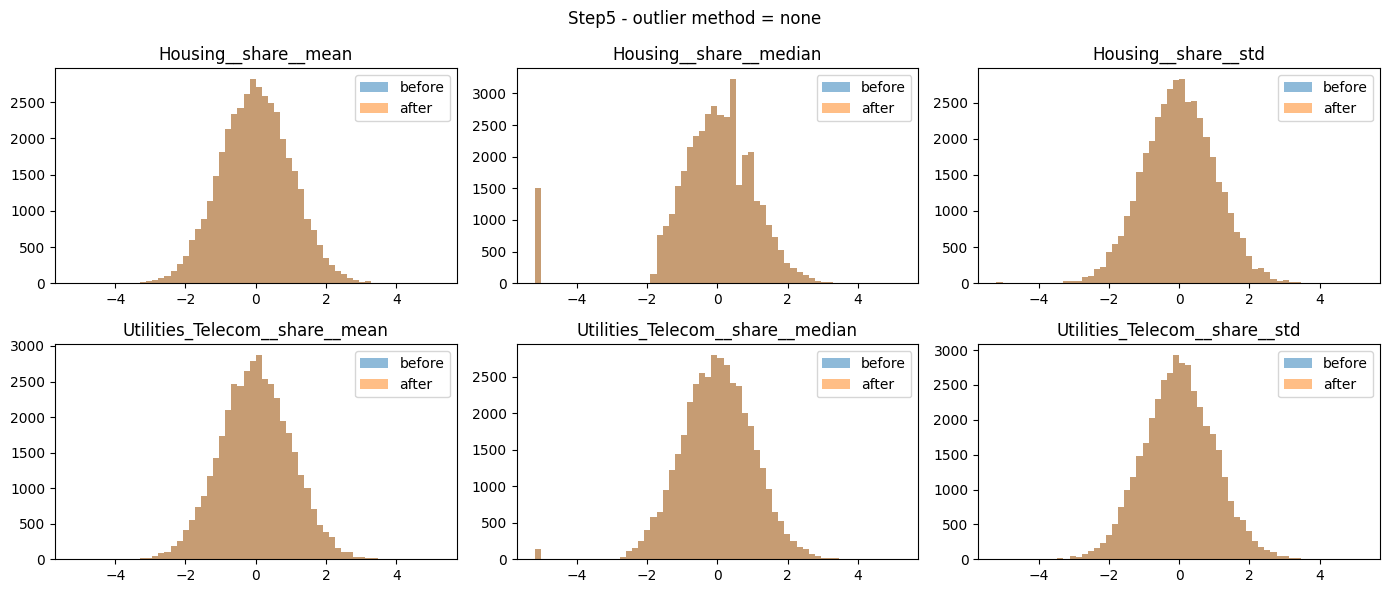

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


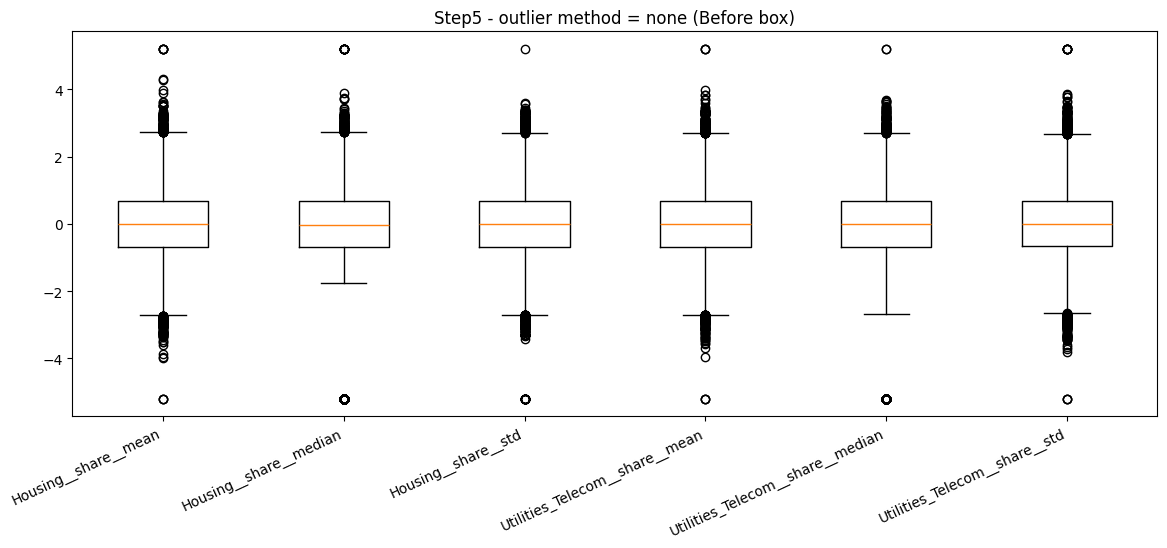

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


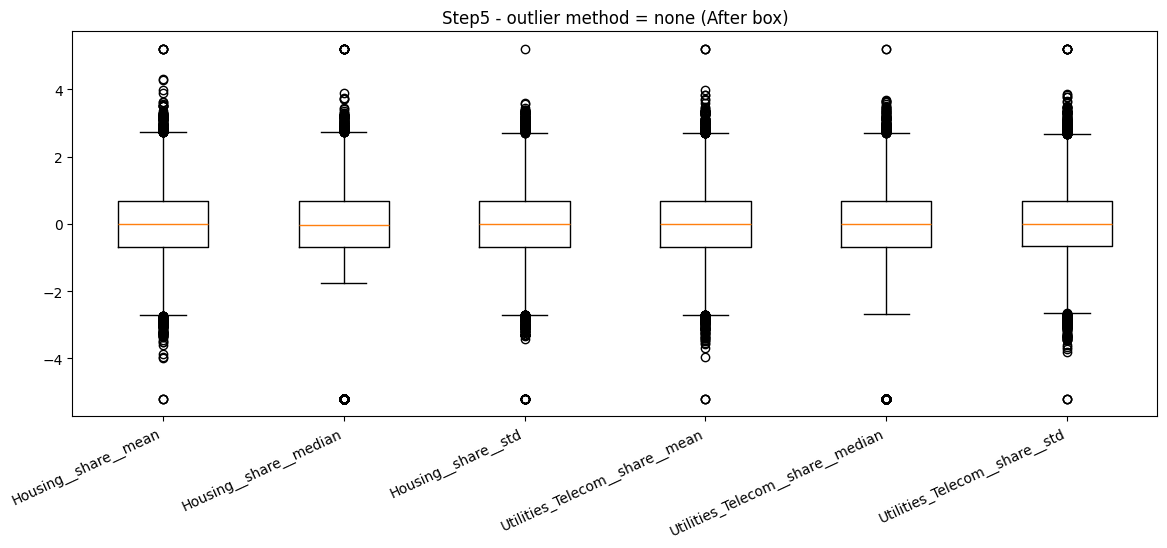

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


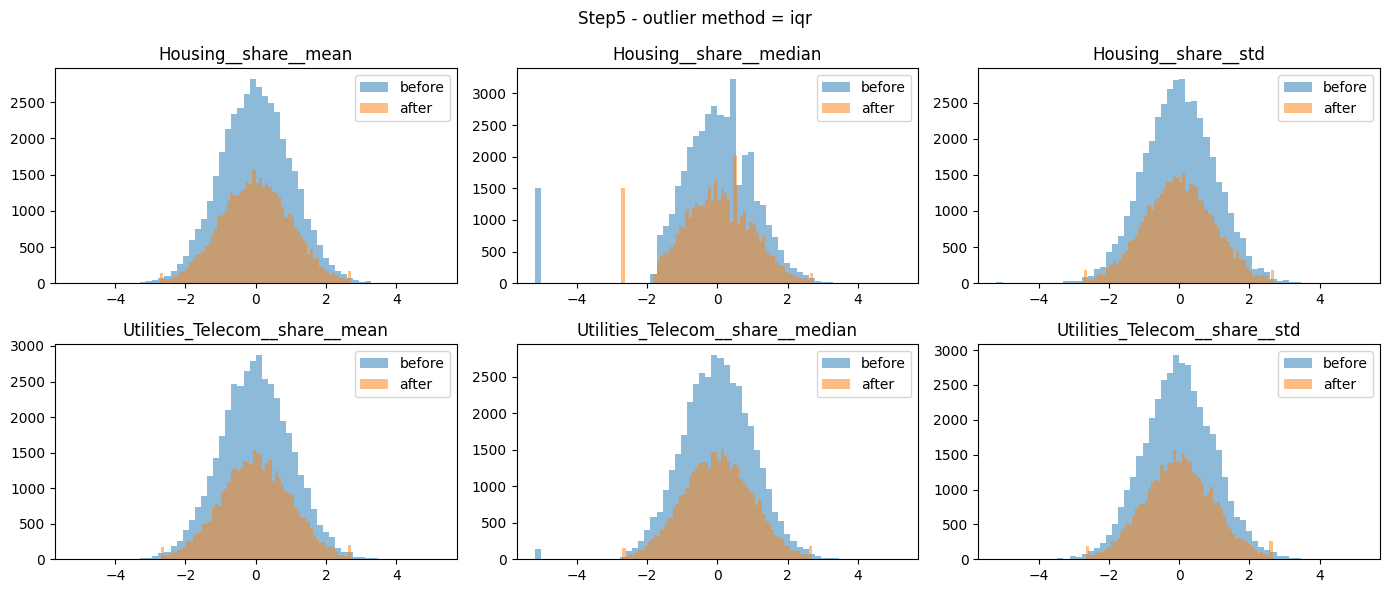

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


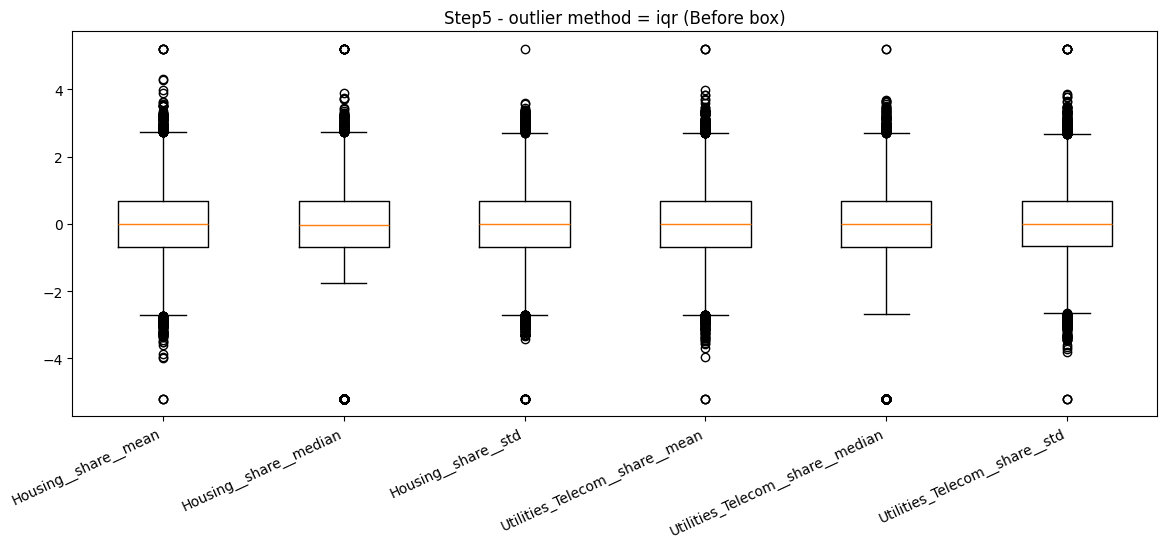

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


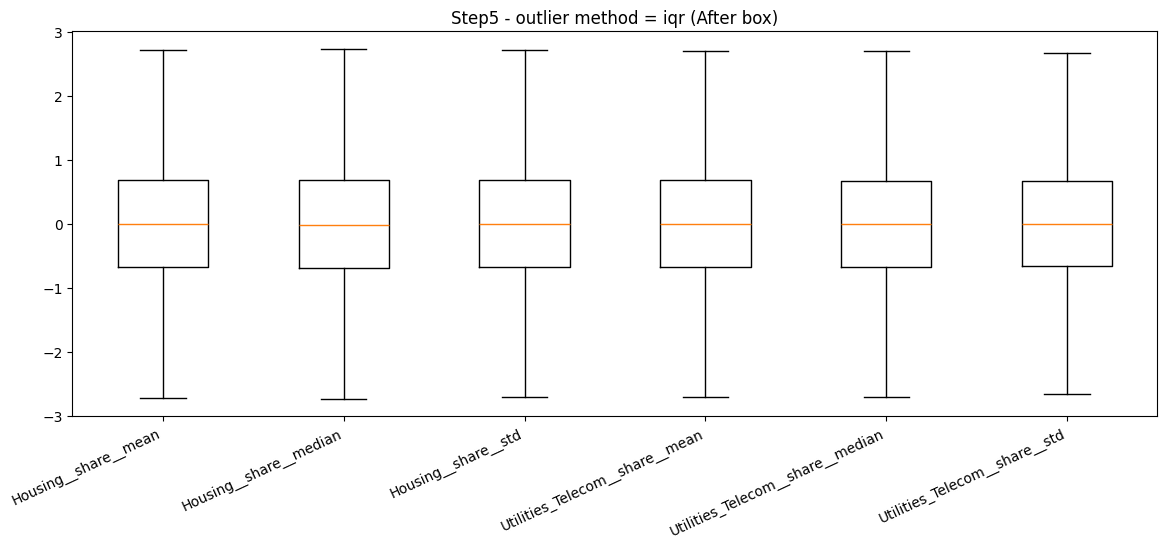

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


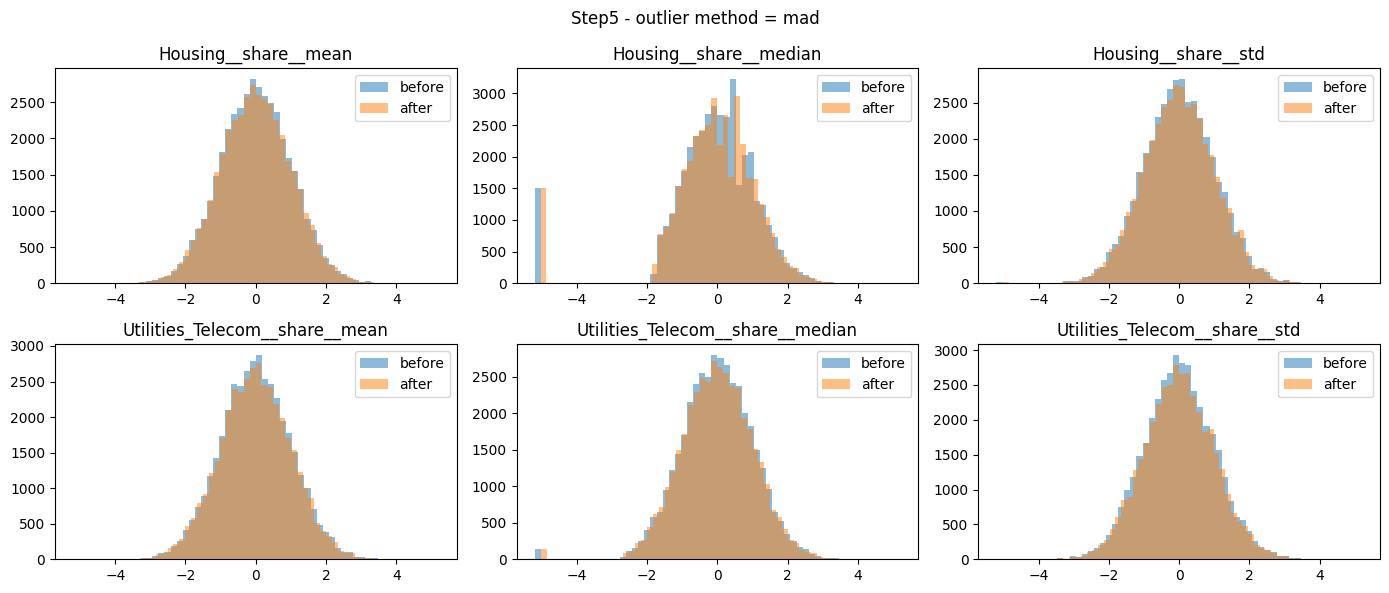

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


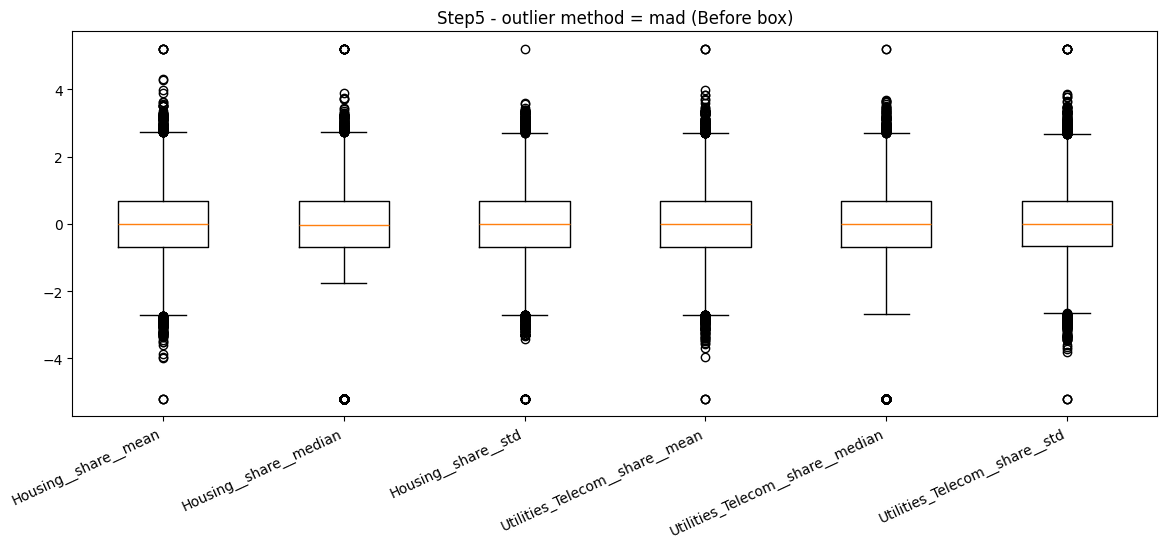

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


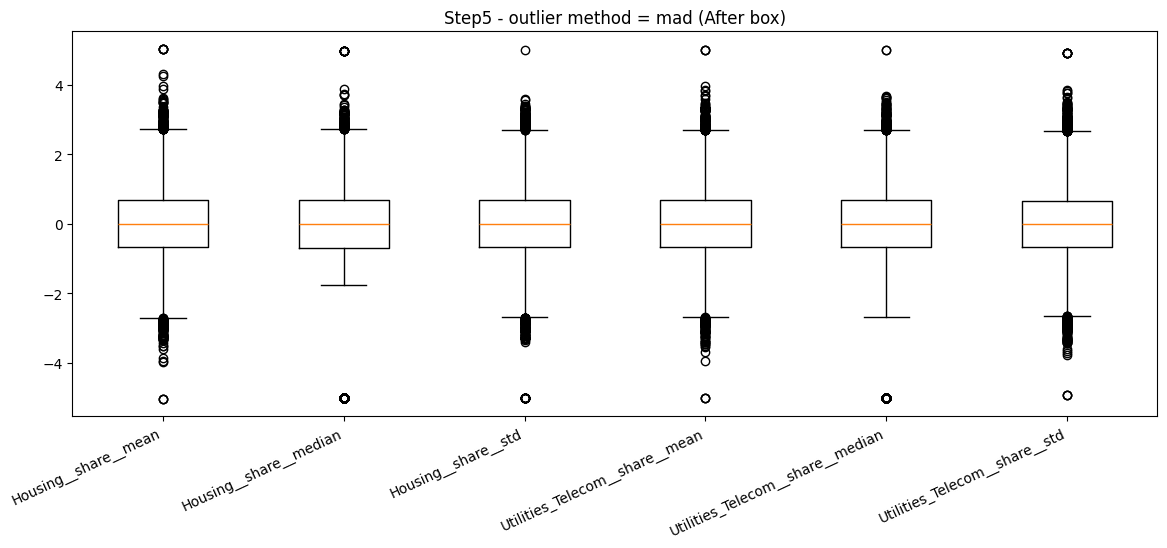

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step5 summary:


outlier_method       acc  macro_f1
1            iqr  0.999625  0.999623
0           none  0.999375  0.999371
2            mad  0.999375  0.999371


Step5 BEST = iqr | acc=0.9996 macro_f1=0.9996


In [9]:
# compare IQR clipping vs MAD clipping, keep best.

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

def fit_iqr_bounds(Xdf, k=1.5):
    q1 = Xdf.quantile(0.25)
    q3 = Xdf.quantile(0.75)
    iqr = (q3 - q1).replace(0, 1e-9)
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    return lo, hi

def fit_mad_bounds(Xdf, z=5.0):
    med = Xdf.median()
    mad = (Xdf - med).abs().median().replace(0, 1e-9)
    lo = med - (z * mad / 0.6745)
    hi = med + (z * mad / 0.6745)
    return lo, hi

def clip_apply(Xdf, lo, hi):
    return Xdf.clip(lower=lo, upper=hi, axis=1)

methods = ["none","iqr","mad"]
plot_feats = list(X.columns[:6])
X_plot = X[plot_feats].copy()

results = []
best = {"method": None, "X": None, "mf1": -1, "acc": -1}

pbar = tqdm(methods, desc="Step5 outlier compare")
for m in pbar:
    if m == "none":
        Xm = X.copy()
        Xp = X_plot.copy()
    elif m == "iqr":
        lo, hi = fit_iqr_bounds(X)
        Xm = clip_apply(X, lo, hi)
        lo2, hi2 = fit_iqr_bounds(X_plot)
        Xp = clip_apply(X_plot, lo2, hi2)
    else:
        lo, hi = fit_mad_bounds(X)
        Xm = clip_apply(X, lo, hi)
        lo2, hi2 = fit_mad_bounds(X_plot)
        Xp = clip_apply(X_plot, lo2, hi2)

    plot_before_after_df(X_plot, Xp, f"Step5 - outlier method = {m}")

    acc, mf1 = quick_eval_lr(Xm, y, groups, scaler_name="standard", penalty_mode=STATE["reg_mode"], C=STATE["reg_params"].get("C",1.0), l1_ratio=STATE["reg_params"].get("l1_ratio",0.5))
    results.append((m, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["mf1"]:
        best.update({"method": m, "X": Xm, "mf1": mf1, "acc": acc})

pbar.close()

res_df = pd.DataFrame(results, columns=["outlier_method","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep5 summary:")
display(res_df)

print(f"\nStep5 BEST = {best['method']} | acc={best['acc']:.4f} macro_f1={best['mf1']:.4f}")

STATE["outlier_method"] = best["method"]
STATE["X_current"] = best["X"]

Feature Selection (Heatmap, VIF, confusion entropy, feature importance) with eval and pick best

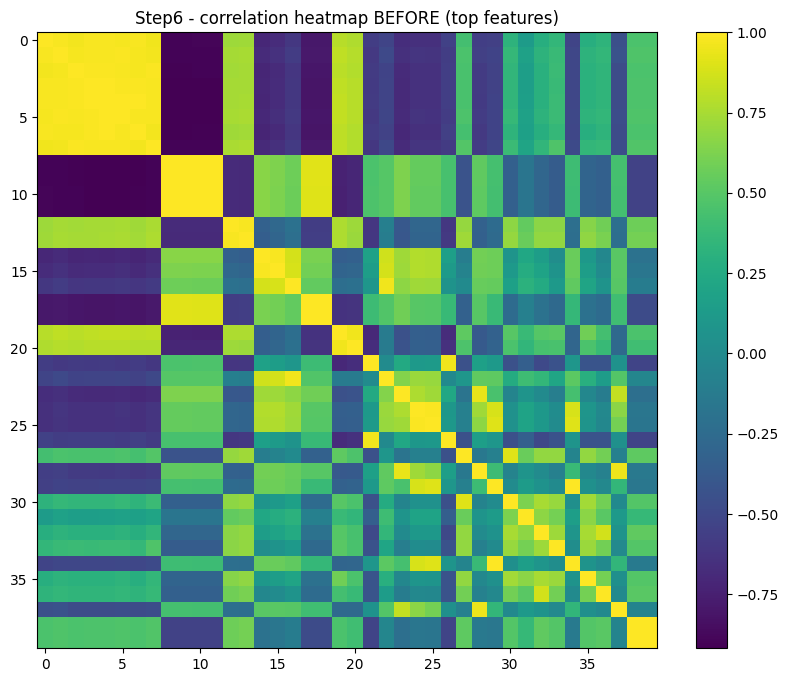

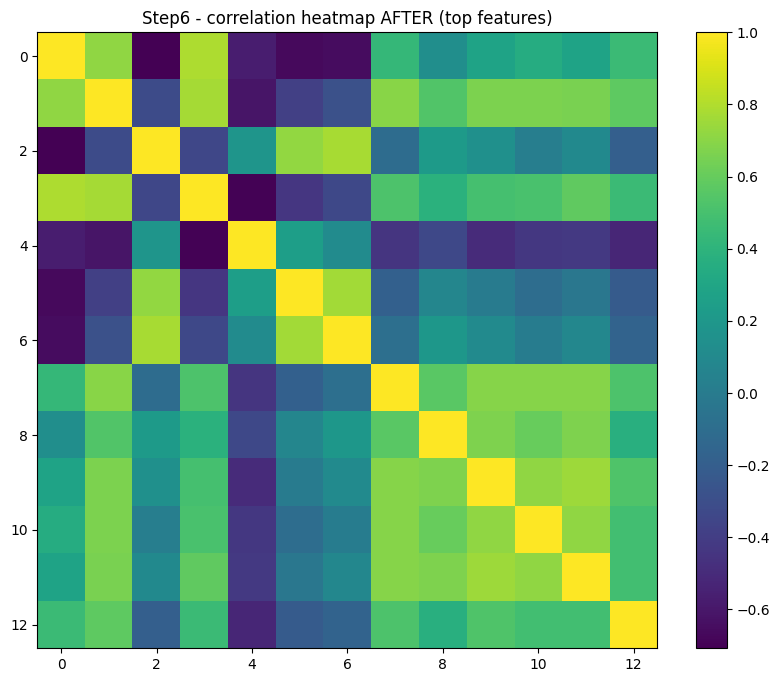

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Heatmap-drop eval: acc=0.9902 macro_f1=0.9903

Top VIFs (secondary check):


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


feature         vif
22                          DebtRate__mean         inf
23              Debt_Payments__share__mean         inf
24                        DebtRate__median  154.861605
14                 Auto_Costs__share__mean   72.135332
13               Auto_Costs__share__median   38.771360
19                  Auto_Costs__share__std   11.855003
0      Groceries_FoodAtHome__share__median    9.330245
9              Healthcare_OOP__share__mean    7.731299
1   Transportation_Variable__share__median    7.724490
20                        Pets__share__std    7.661936
16           Healthcare_OOP__share__median    6.814119
21                       Pets__share__mean    6.713043
3               Insurance_All__share__mean    6.317985
12                           DebtRate__std    5.989266
2             Entertainment__share__median    4.762670

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



VIF-drop eval: acc=0.9910 macro_f1=0.9910


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Entropy-wrapper baseline: score=0.9772 f1=0.9910 ent=0.0552 (features=31)


Entropy-wrapper pruning:   0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi


Entropy-wrapper final feature count: 27
last drops: [('DebtRate__std', 0.9775651292378131, 0.9911472181189622, 0.054328355524596146, 30), ('Entertainment__share__std', 0.9784301154339432, 0.9915227399432612, 0.05237049803727228, 29), ('Debt_Payments__share__median', 0.979268781265177, 0.9918904584420206, 0.05048670870737448, 28), ('Pets__share__std', 0.9795050698040246, 0.9920161186795537, 0.050044195502116605, 27)]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Entropy-selected eval: acc=0.9920 macro_f1=0.9920


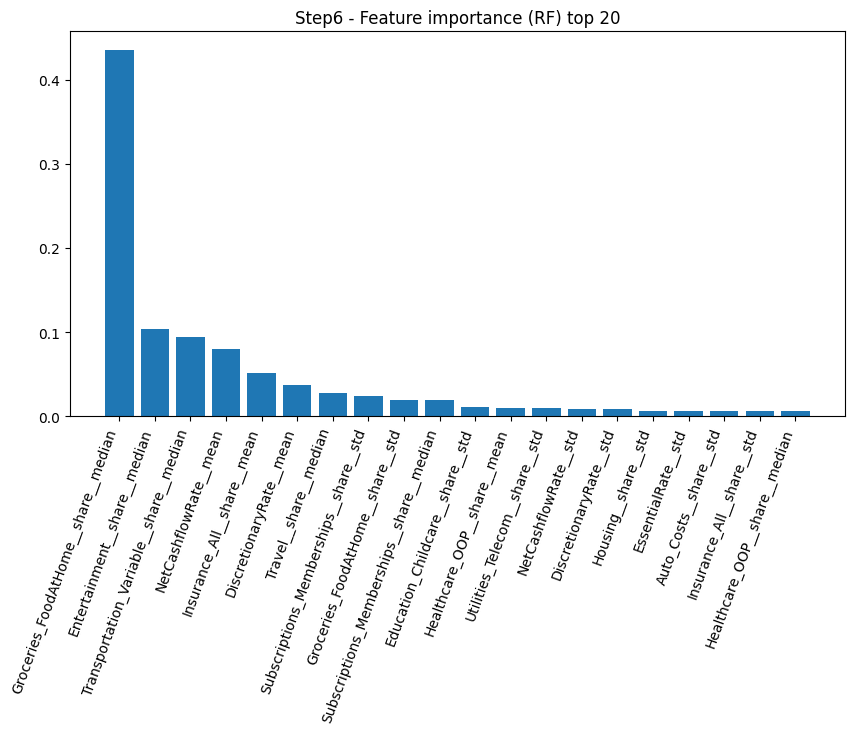


Step6 BEST feature set = entropy_selected | acc=0.9920 macro_f1=0.9920 | features=27


In [10]:
# must include: heatmap, VIF, confusion entropy, and feature importance.
# done in stages and kept the best feature set.

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_classif

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

# optionally cap rows for heavy stuff
df_people = STATE["df_people"]
if FAST_MODE and len(df_people) > PEOPLE_CAP_FAST:
    idx = df_people.sample(n=PEOPLE_CAP_FAST, random_state=RANDOM_SEED).index
    X_fs = X.loc[idx].copy()
    y_fs = y[idx]
    groups_fs = groups[idx]
else:
    X_fs, y_fs, groups_fs = X.copy(), y.copy(), groups.copy()

# ---- (A) Heatmap correlation ----
# show only top 40 MI features for heatmap
mi = mutual_info_classif(X_fs.values, y_fs, random_state=RANDOM_SEED)
mi_rank = pd.Series(mi, index=X_fs.columns).sort_values(ascending=False)
top_heat = list(mi_rank.head(min(40, len(mi_rank))).index)

corr_before = X_fs[top_heat].corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr_before.values, aspect="auto")
plt.title("Step6 - correlation heatmap BEFORE (top features)")
plt.colorbar()
plt.show()

to_drop = set()
th = 0.85
for i in range(len(top_heat)):
    for j in range(i+1, len(top_heat)):
        if abs(corr_before.iloc[i, j]) > th:
            # drop the lower-MI feature
            fi, fj = top_heat[i], top_heat[j]
            drop = fj if mi_rank[fi] >= mi_rank[fj] else fi
            to_drop.add(drop)

X_h = X.drop(columns=list(to_drop), errors="ignore")

corr_after = X_fs[[c for c in top_heat if c in X_h.columns]].corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr_after.values, aspect="auto")
plt.title("Step6 - correlation heatmap AFTER (top features)")
plt.colorbar()
plt.show()

acc_h, mf1_h = quick_eval_lr(X_h, y, groups, scaler_name="standard", penalty_mode=STATE["reg_mode"],
                            C=STATE["reg_params"].get("C",1.0), l1_ratio=STATE["reg_params"].get("l1_ratio",0.5))
print(f"\nHeatmap-drop eval: acc={acc_h:.4f} macro_f1={mf1_h:.4f}")

# ---- (B) VIF secondary (run on reduced with only for top 25 to keep it fast) ----
def compute_vif(Xdf):
    Xv = Xdf.values.astype(np.float64)
    out = []
    for i in range(Xv.shape[1]):
        out.append((Xdf.columns[i], variance_inflation_factor(Xv, i)))
    return pd.DataFrame(out, columns=["feature","vif"]).sort_values("vif", ascending=False)

vif_base_cols = list(mi_rank[ [c in X_h.columns for c in mi_rank.index] ].head(min(25, len(X_h.columns))).index)
vif_df = compute_vif(X_h[vif_base_cols].dropna())
print("\nTop VIFs (secondary check):")
display(vif_df.head(15))

# optional VIF rule
vif_drop = list(vif_df[vif_df["vif"] > 12]["feature"].values)
X_v = X_h.drop(columns=vif_drop, errors="ignore")
acc_v, mf1_v = quick_eval_lr(X_v, y, groups, scaler_name="standard", penalty_mode=STATE["reg_mode"],
                            C=STATE["reg_params"].get("C",1.0), l1_ratio=STATE["reg_params"].get("l1_ratio",0.5))
print(f"\nVIF-drop eval: acc={acc_v:.4f} macro_f1={mf1_v:.4f}")

# ---- (C) Confusion-matrix entropy (main) ----
def confusion_entropy(cm):
    cm = cm.astype(np.float64)
    rs = cm.sum(axis=1, keepdims=True)
    rs[rs == 0] = 1.0
    p = cm / rs
    p = np.clip(p, 1e-12, 1.0)
    ent = -(p * np.log(p)).sum(axis=1)
    return float(ent.mean())

def score_features(Xdf, y, groups, feature_list, lambda_ent=0.25):
    Xs = Xdf[feature_list]
    tr_idx, te_idx = split_by_group(Xs, y, groups)

    Xtr = Xs.iloc[tr_idx].values
    Xte = Xs.iloc[te_idx].values
    ytr = y[tr_idx]
    yte = y[te_idx]

    sc = StandardScaler()
    sc.fit(Xtr)
    Xtr = sc.transform(Xtr)
    Xte = sc.transform(Xte)

    # use your chosen reg mode
    mode = STATE["reg_mode"]
    params = STATE["reg_params"]
    if mode == "elasticnet":
        model = LogisticRegression(multi_class="multinomial", solver="saga", penalty="elasticnet",
                                   l1_ratio=params.get("l1_ratio",0.5), C=params.get("C",1.0),
                                   max_iter=900, n_jobs=-1, random_state=RANDOM_SEED)
    elif mode == "l1":
        model = LogisticRegression(multi_class="multinomial", solver="saga", penalty="l1",
                                   C=params.get("C",1.0), max_iter=900, n_jobs=-1, random_state=RANDOM_SEED)
    else:
        model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=700, n_jobs=-1)

    model.fit(Xtr, ytr)
    pred = model.predict(Xte)

    mf1 = f1_score(yte, pred, average="macro")
    cm = confusion_matrix(yte, pred, labels=list(range(6)))
    ent = confusion_entropy(cm)
    score = float(mf1 - lambda_ent * ent)
    return score, mf1, ent

# candidate pool = top K MI (on X_v)
mi2 = mutual_info_classif(X_fs[[c for c in X_v.columns if c in X_fs.columns]].values, y_fs, random_state=RANDOM_SEED)
mi2_rank = pd.Series(mi2, index=[c for c in X_v.columns if c in X_fs.columns]).sort_values(ascending=False)
K = min(50, len(mi2_rank))
selected = list(mi2_rank.head(K).index)

base_score, base_f1, base_ent = score_features(X_v, y, groups, selected)
print(f"\nEntropy-wrapper baseline: score={base_score:.4f} f1={base_f1:.4f} ent={base_ent:.4f} (features={len(selected)})")

improved = True
hist = []
pbar = tqdm(total=max(0, len(selected)-15), desc="Entropy-wrapper pruning")
while improved and len(selected) > 15:
    improved = False
    best_local = (base_score, None, None, None)

    for f in selected:
        trial = [x for x in selected if x != f]
        sc, f1v, entv = score_features(X_v, y, groups, trial)
        if sc > best_local[0] + 1e-4:
            best_local = (sc, f, f1v, entv)

    if best_local[1] is not None:
        drop_f = best_local[1]
        selected.remove(drop_f)
        base_score, base_f1, base_ent = best_local[0], best_local[2], best_local[3]
        hist.append((drop_f, base_score, base_f1, base_ent, len(selected)))
        improved = True
        pbar.update(1)
        pbar.set_postfix({"score": f"{base_score:.3f}", "f1": f"{base_f1:.3f}", "ent": f"{base_ent:.3f}", "k": len(selected)})

pbar.close()

print("\nEntropy-wrapper final feature count:", len(selected))
print("last drops:", hist[-5:])

X_e = X_v[selected].copy()
acc_e, mf1_e = quick_eval_lr(X_e, y, groups, scaler_name="standard", penalty_mode=STATE["reg_mode"],
                            C=STATE["reg_params"].get("C",1.0), l1_ratio=STATE["reg_params"].get("l1_ratio",0.5))
print(f"\nEntropy-selected eval: acc={acc_e:.4f} macro_f1={mf1_e:.4f}")

# ---- (D) Feature importance (RF) ----
rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1)
tr_idx, te_idx = split_by_group(X_e, y, groups)
rf.fit(X_e.iloc[tr_idx].values, y[tr_idx])
imp = pd.Series(rf.feature_importances_, index=X_e.columns).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 5))
plt.bar(imp.index, imp.values)
plt.title("Step6 - Feature importance (RF) top 20")
plt.xticks(rotation=70, ha="right")
plt.show()

# pick best among heatmap, vif, entropy
cands = [
    ("heatmap_drop", X_h, mf1_h, acc_h),
    ("vif_drop", X_v, mf1_v, acc_v),
    ("entropy_selected", X_e, mf1_e, acc_e),
]
best = sorted(cands, key=lambda x: x[2], reverse=True)[0]
print(f"\nStep6 BEST feature set = {best[0]} | acc={best[3]:.4f} macro_f1={best[2]:.4f} | features={best[1].shape[1]}")

STATE["feature_select_method"] = best[0]
STATE["X_current"] = best[1]
STATE["feature_cols"] = list(best[1].columns)

Data Scaling (Z-score and more) with before/after plots, eval, and pick best

Step7 scaling compare:   0%|          | 0/4 [00:00<?, ?it/s]

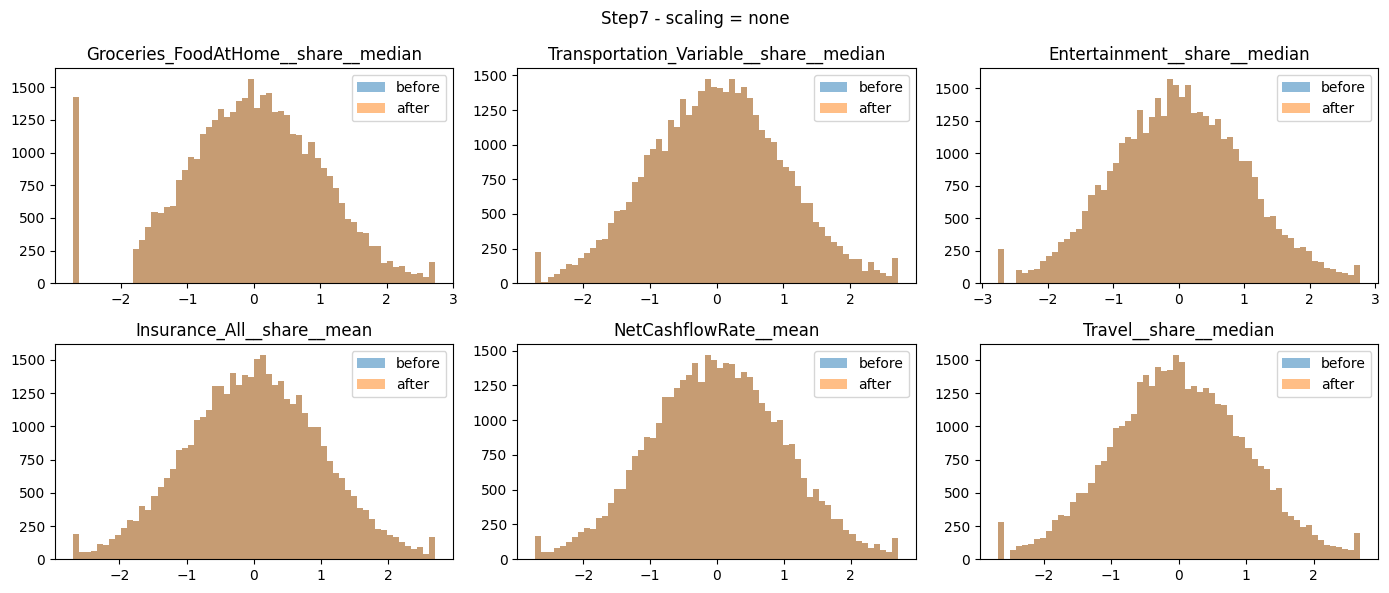

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


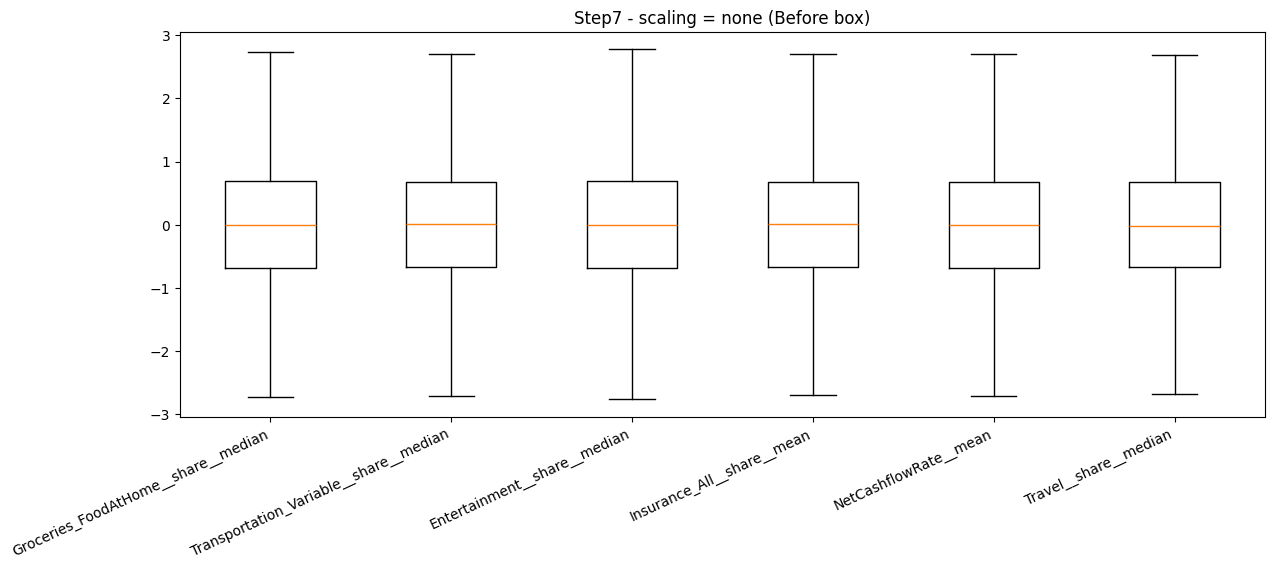

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


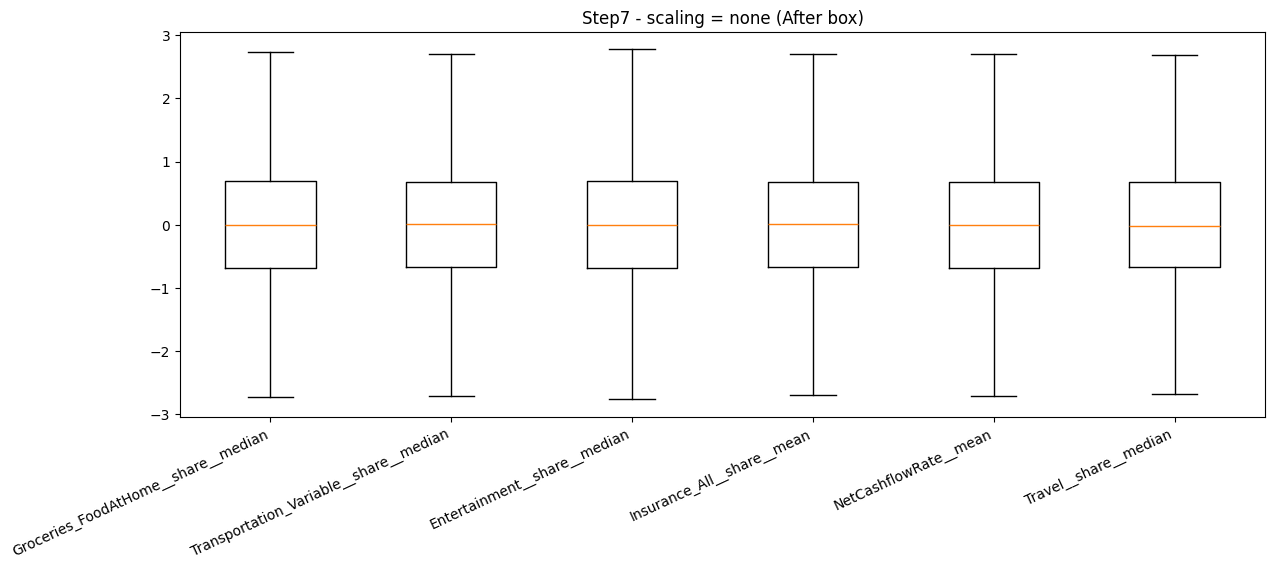

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


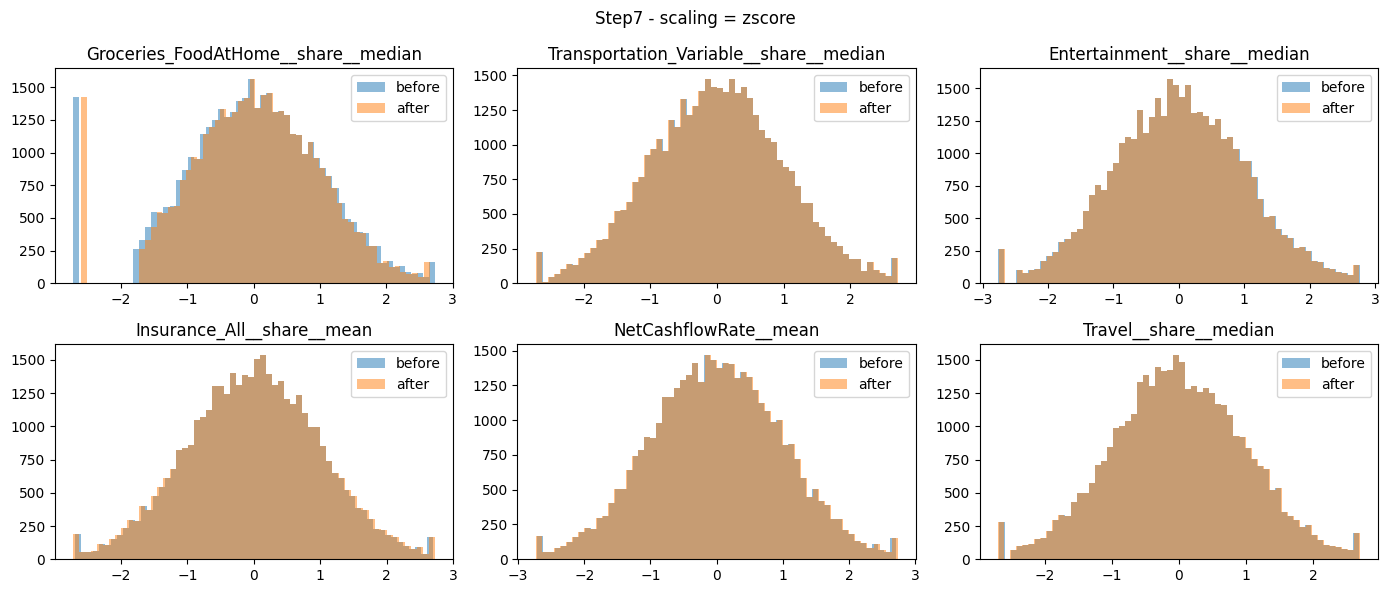

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


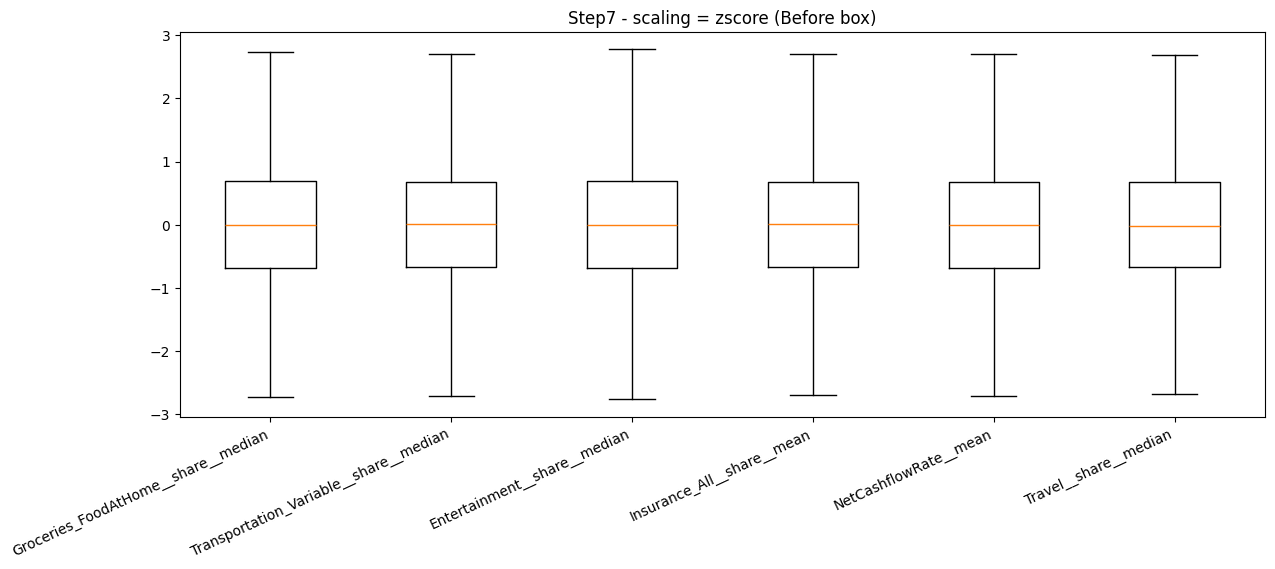

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


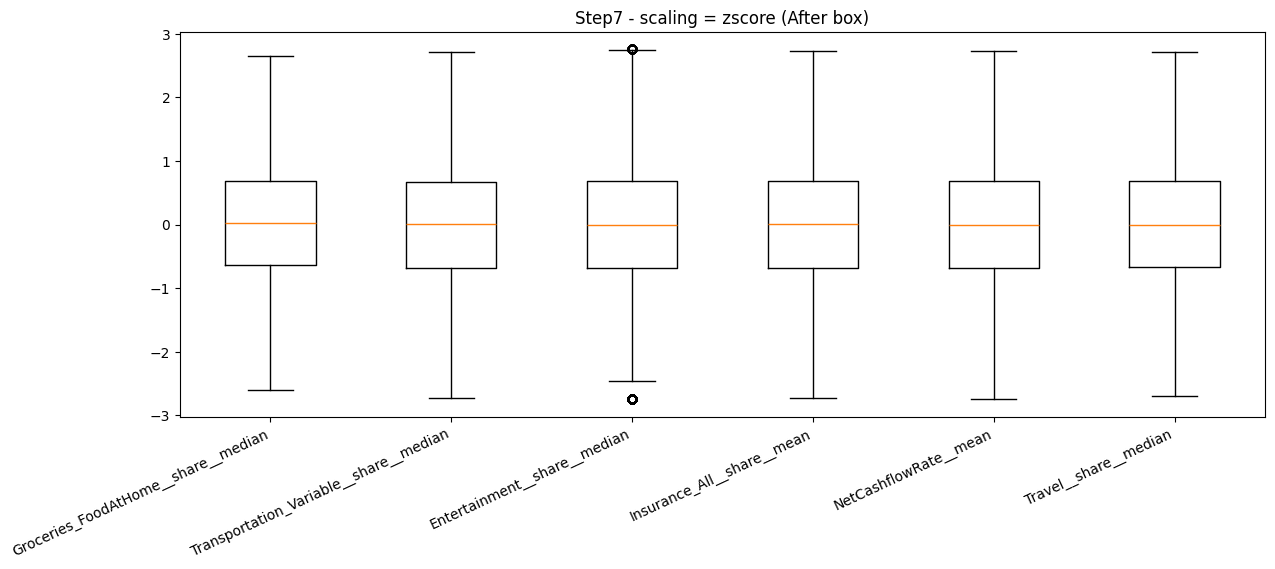

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


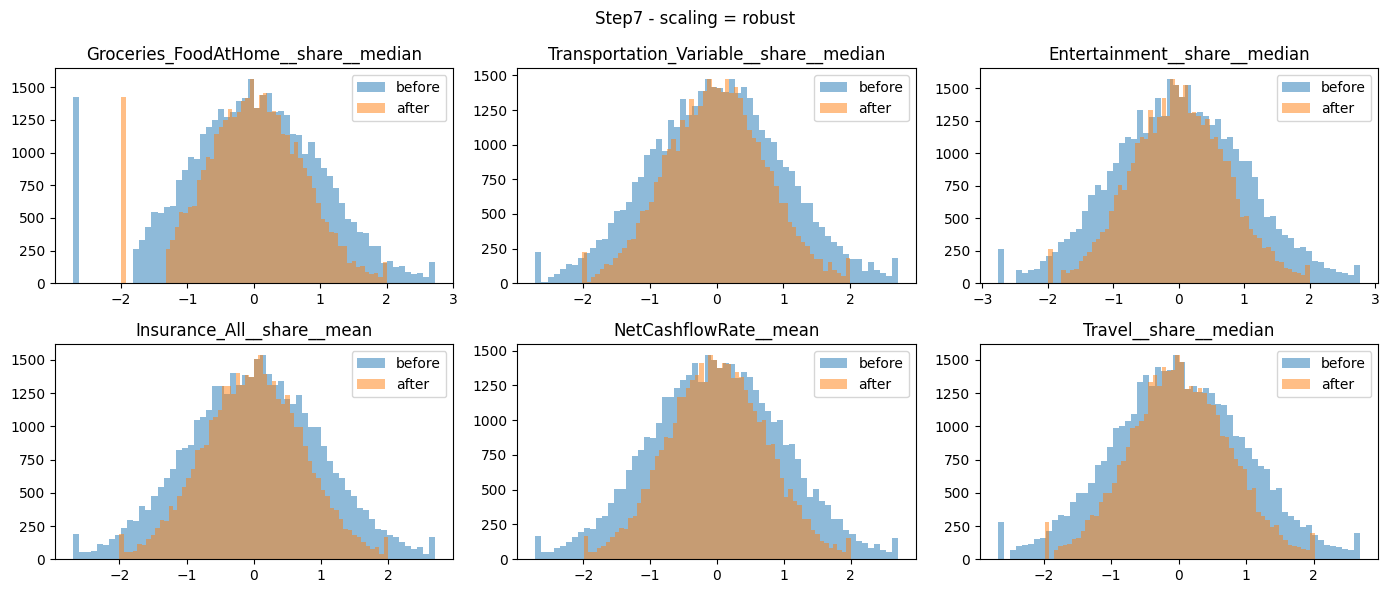

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


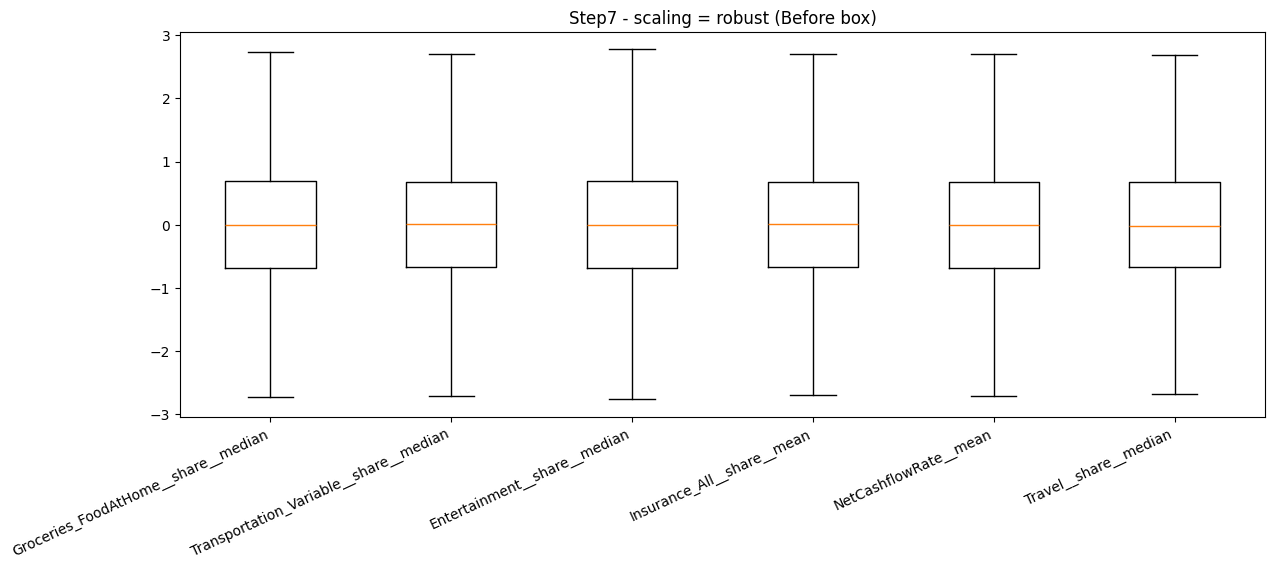

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


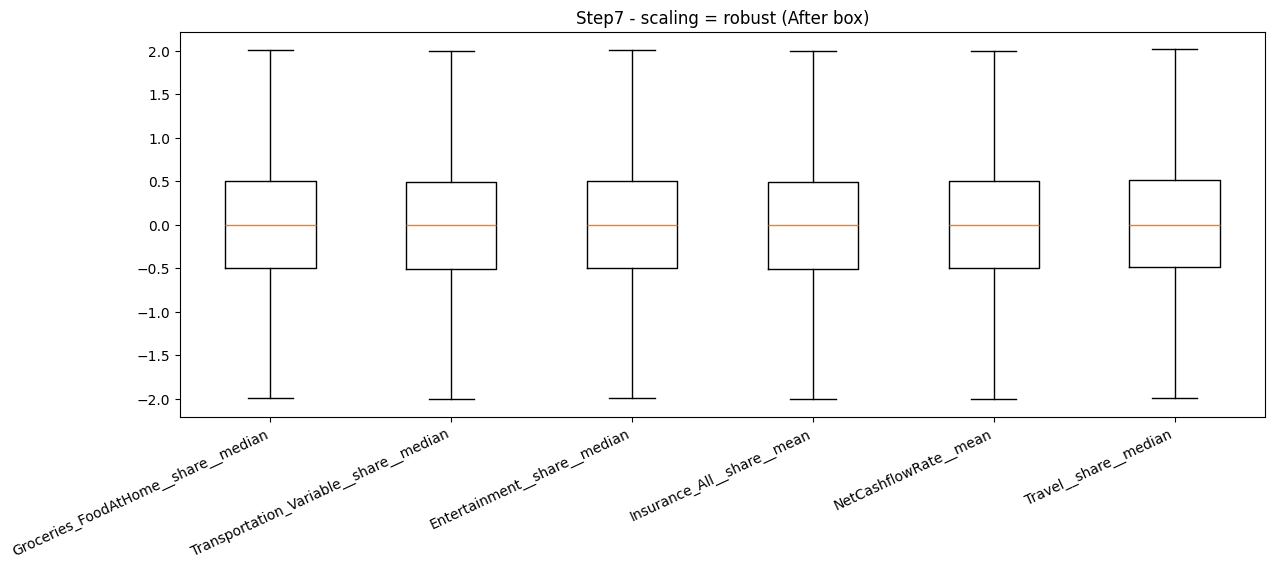

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


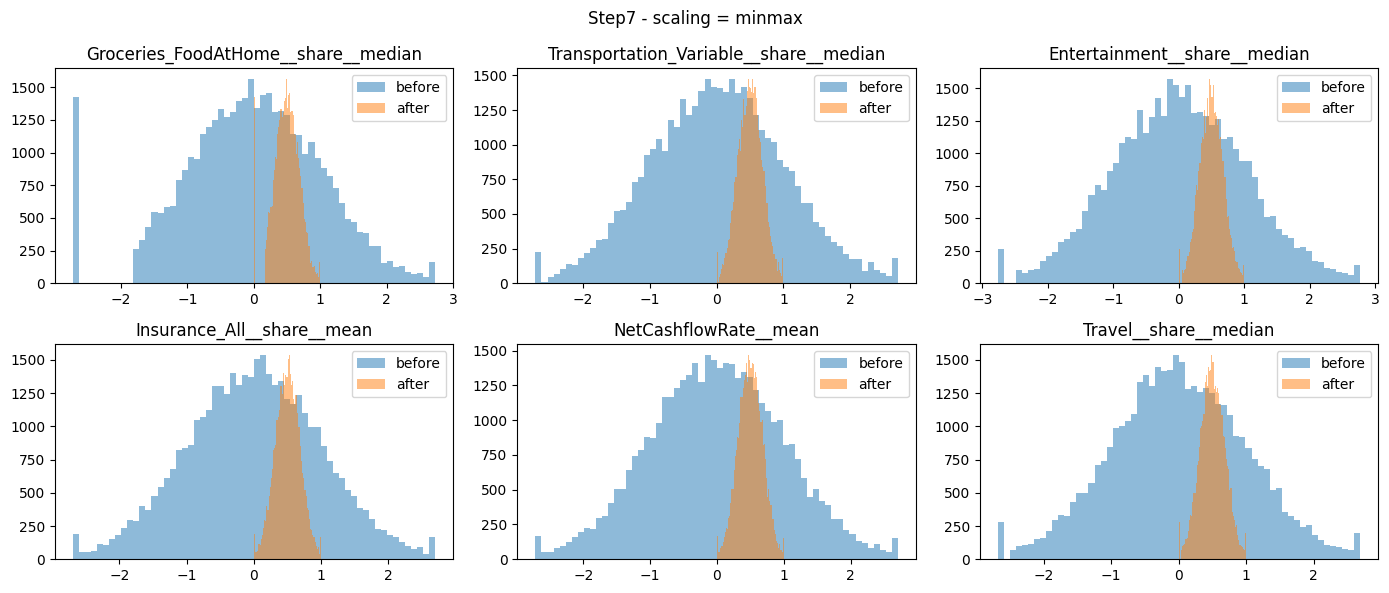

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


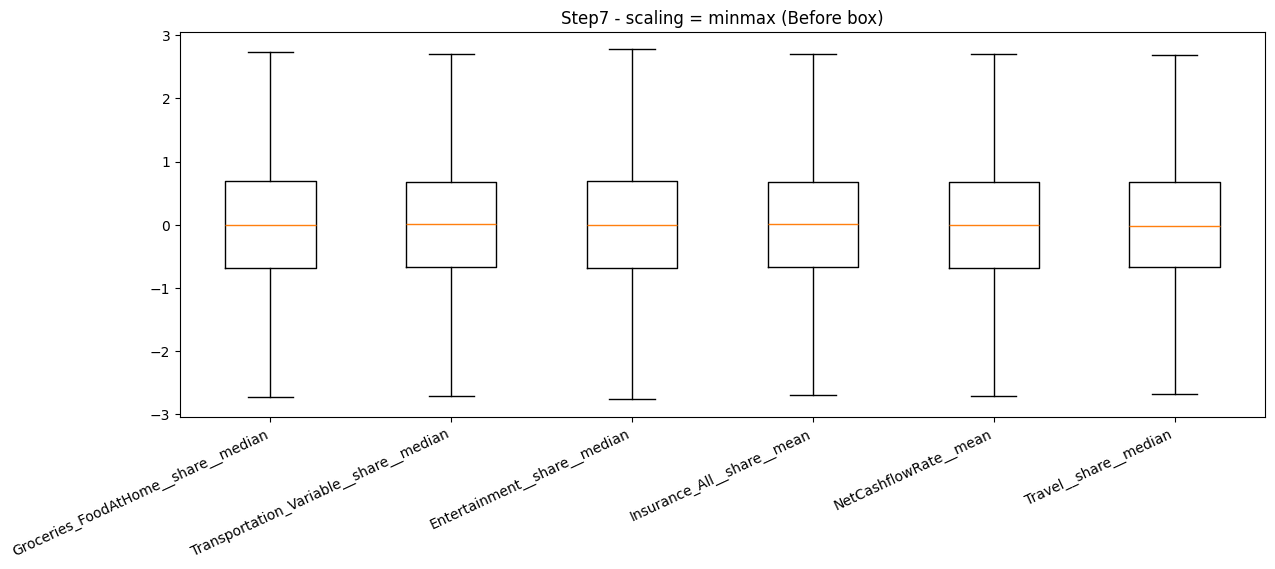

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


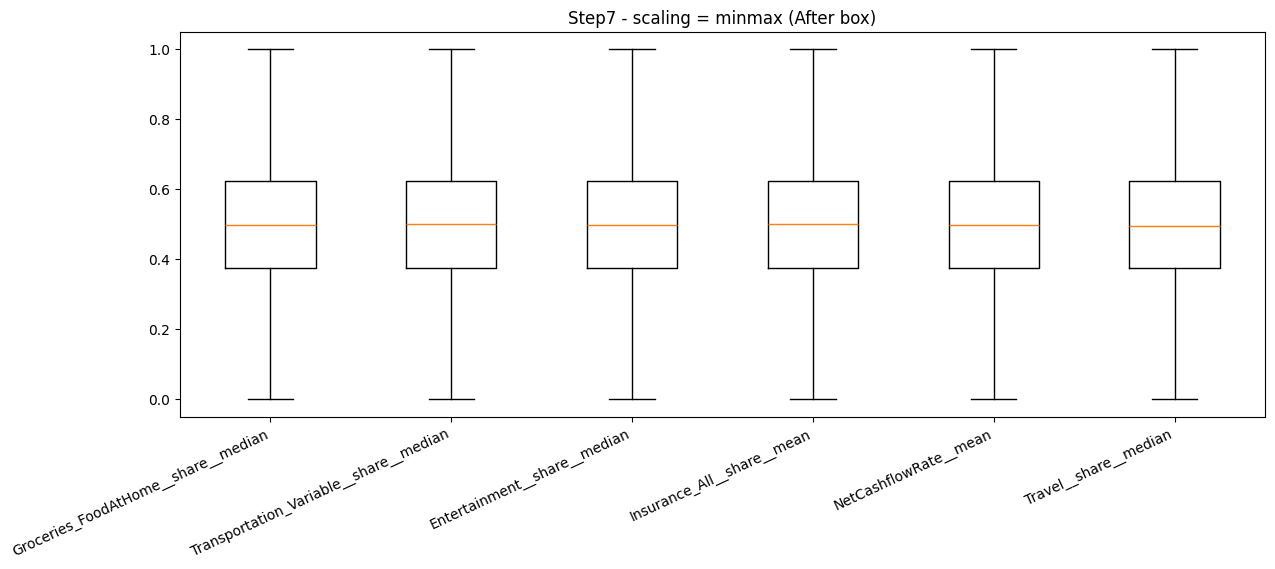

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step7 summary:


scaler       acc  macro_f1
0    none  0.992125  0.992141
1  zscore  0.992000  0.992016
2  robust  0.990625  0.990645
3  minmax  0.964500  0.964651


Step7 BEST = none | acc=0.9921 macro_f1=0.9921


In [11]:
# compare scalers, show before/after plots, eval, keep best.

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

scalers = ["none", "zscore", "robust", "minmax"]

plot_feats = list(X.columns[:6])
X_plot = X[plot_feats].copy()

def apply_scaler_df(Xdf, scaler_name):
    if scaler_name == "none":
        return Xdf.copy(), None
    if scaler_name == "zscore":
        sc = StandardScaler()
    elif scaler_name == "robust":
        sc = RobustScaler()
    elif scaler_name == "minmax":
        sc = MinMaxScaler()
    else:
        raise ValueError(scaler_name)

    Xt = pd.DataFrame(sc.fit_transform(Xdf.values), columns=Xdf.columns, index=Xdf.index)
    return Xt, sc

results = []
best = {"scaler": None, "X": None, "mf1": -1, "acc": -1, "scaler_obj": None}

pbar = tqdm(scalers, desc="Step7 scaling compare")
for s in pbar:
    Xs, sc_obj = apply_scaler_df(X, s)
    Xp_after, _ = apply_scaler_df(X_plot, s)
    plot_before_after_df(X_plot, Xp_after, f"Step7 - scaling = {s}")

    # eval using LR (scaling affects LR the most)
    # NOTE: since already scaled in Xs, set scaler_name="none" in eval
    acc, mf1 = quick_eval_lr(Xs, y, groups, scaler_name="none", penalty_mode=STATE["reg_mode"],
                            C=STATE["reg_params"].get("C",1.0), l1_ratio=STATE["reg_params"].get("l1_ratio",0.5))
    results.append((s, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["mf1"]:
        best.update({"scaler": s, "X": Xs, "mf1": mf1, "acc": acc, "scaler_obj": sc_obj})

pbar.close()

res_df = pd.DataFrame(results, columns=["scaler","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep7 summary:")
display(res_df)

print(f"\nStep7 BEST = {best['scaler']} | acc={best['acc']:.4f} macro_f1={best['mf1']:.4f}")

STATE["scaler_method"] = best["scaler"]
STATE["scaler_obj"] = best["scaler_obj"]
STATE["X_current"] = best["X"]

Standardization with before/after plots, eval, and pick best

Step8 standardization compare:   0%|          | 0/3 [00:00<?, ?it/s]

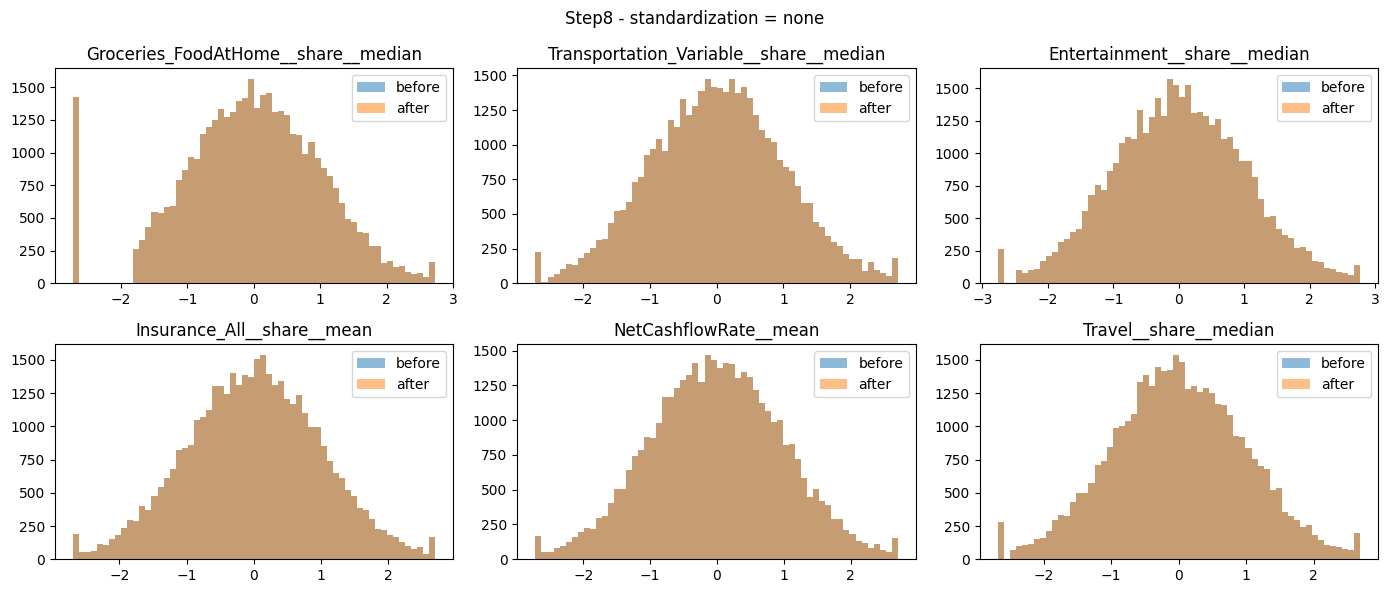

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


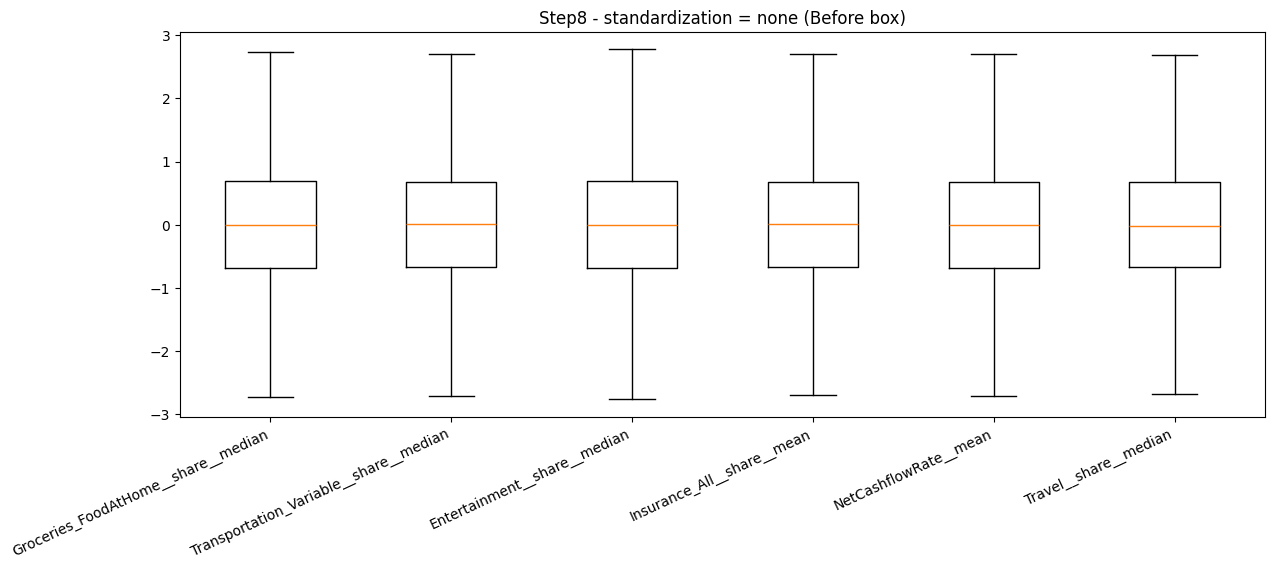

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


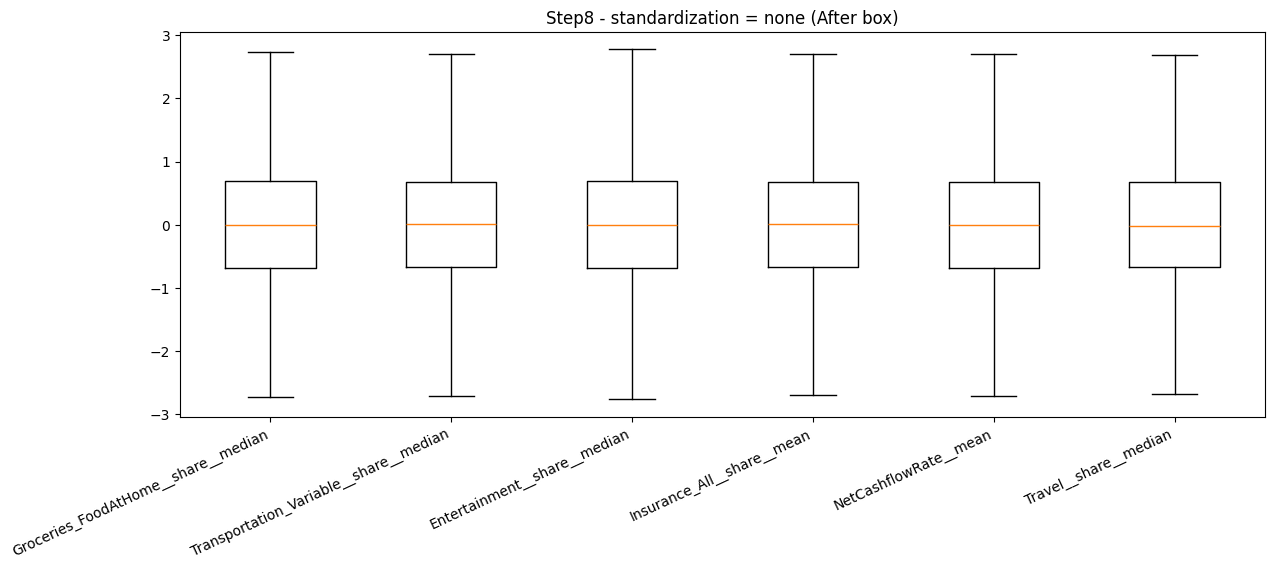

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


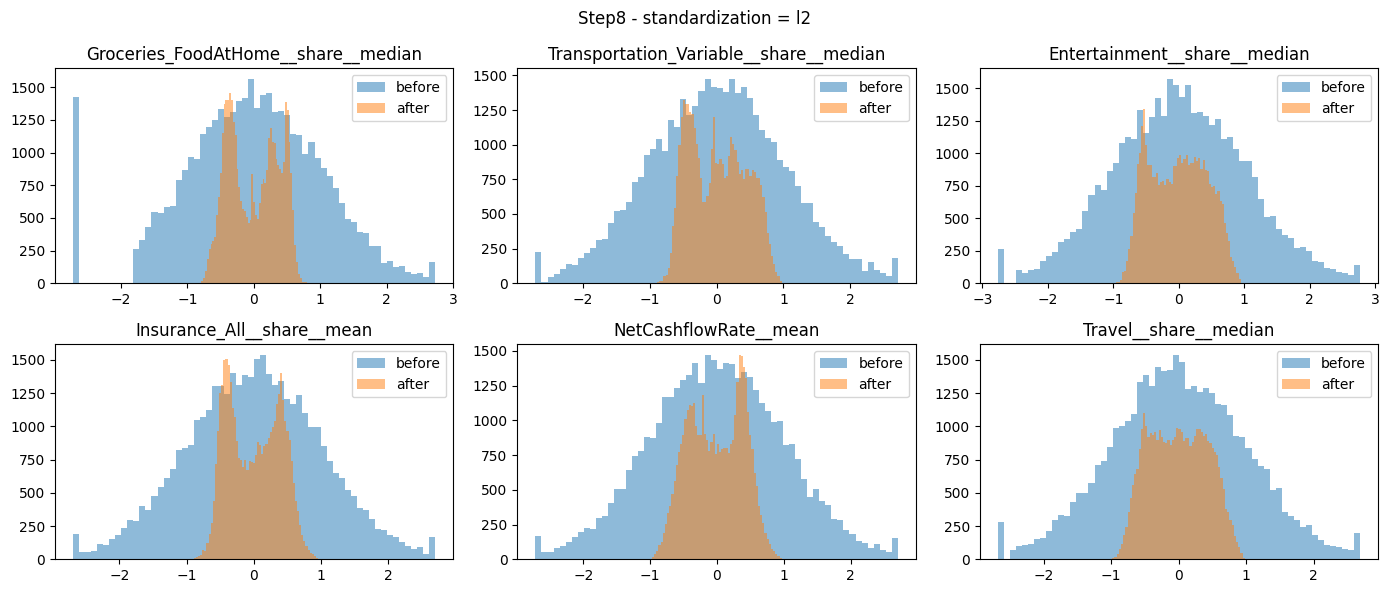

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


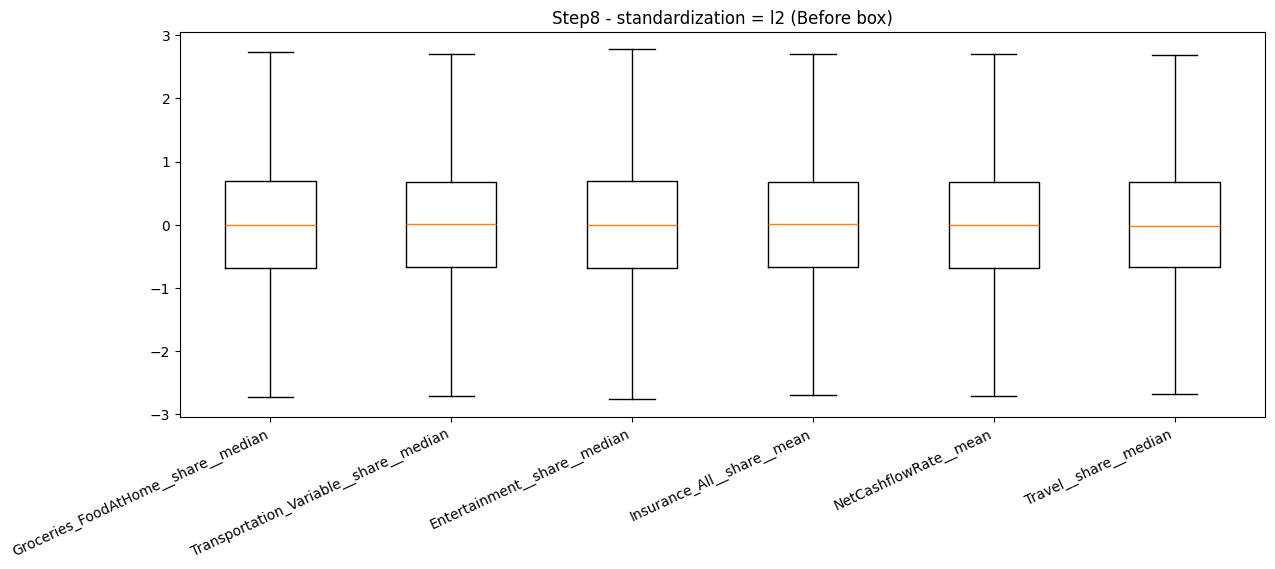

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


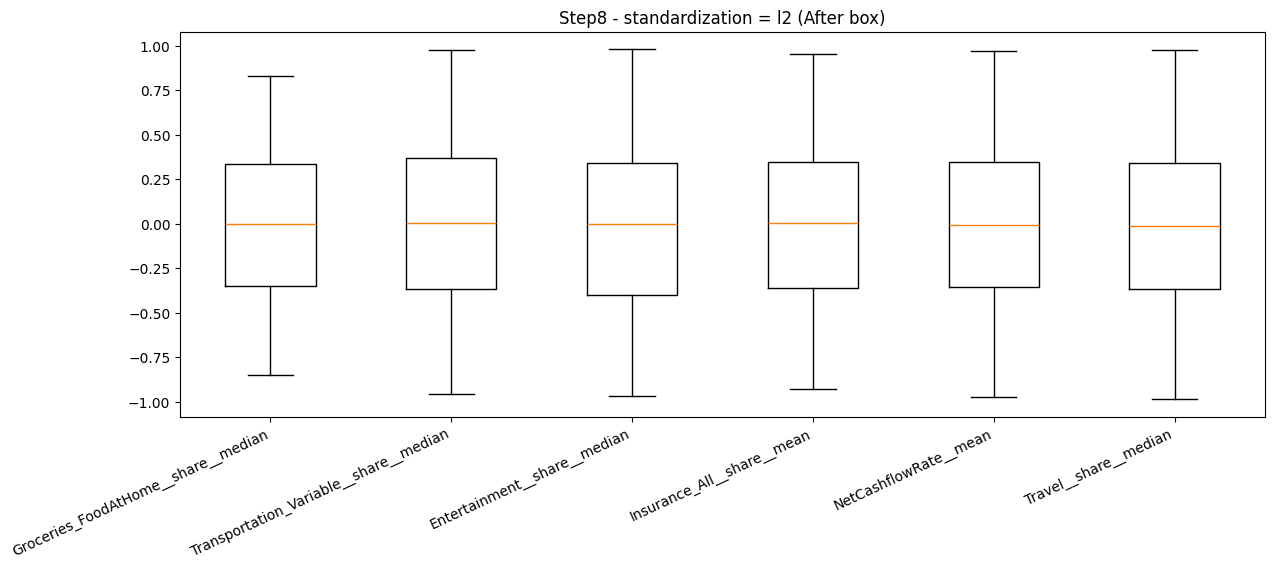

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


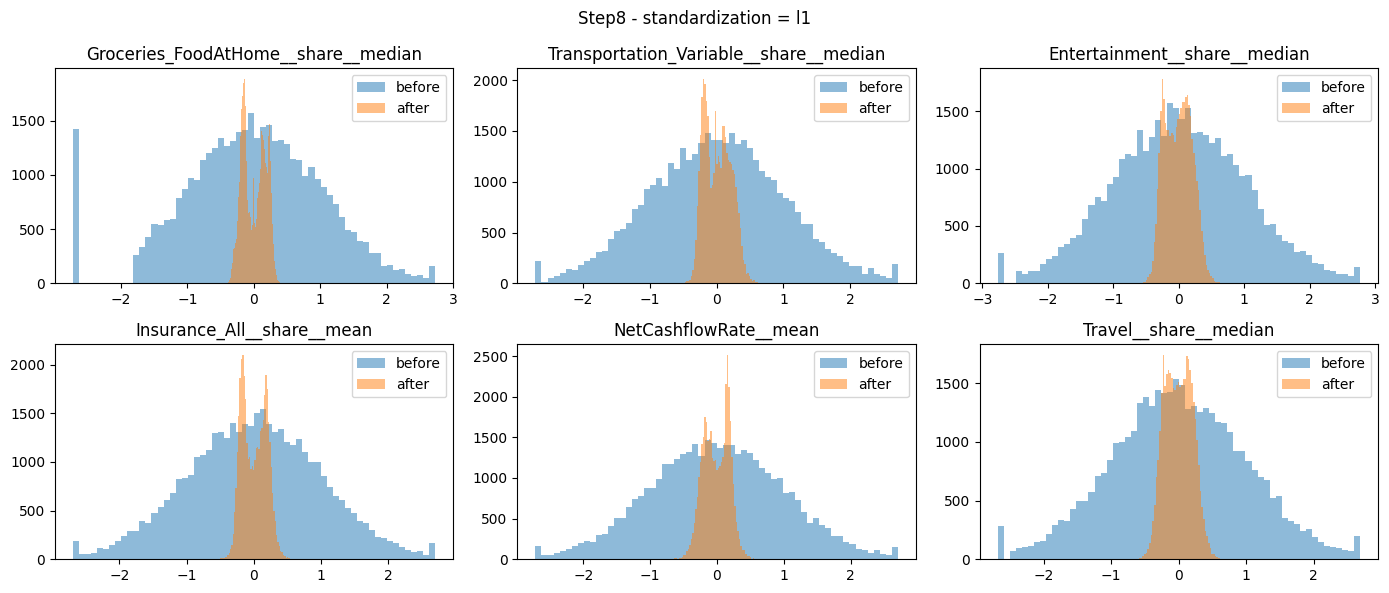

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


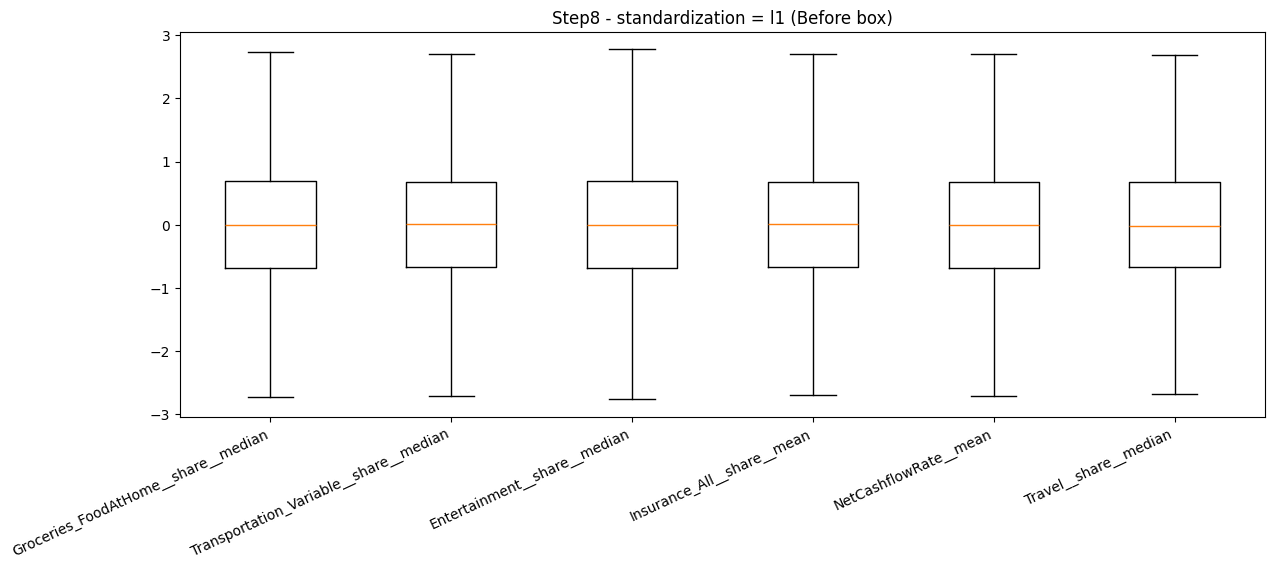

/tmp/ipython-input-3501638331.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([sample[c].values for c in cols2], labels=cols2, showfliers=True)


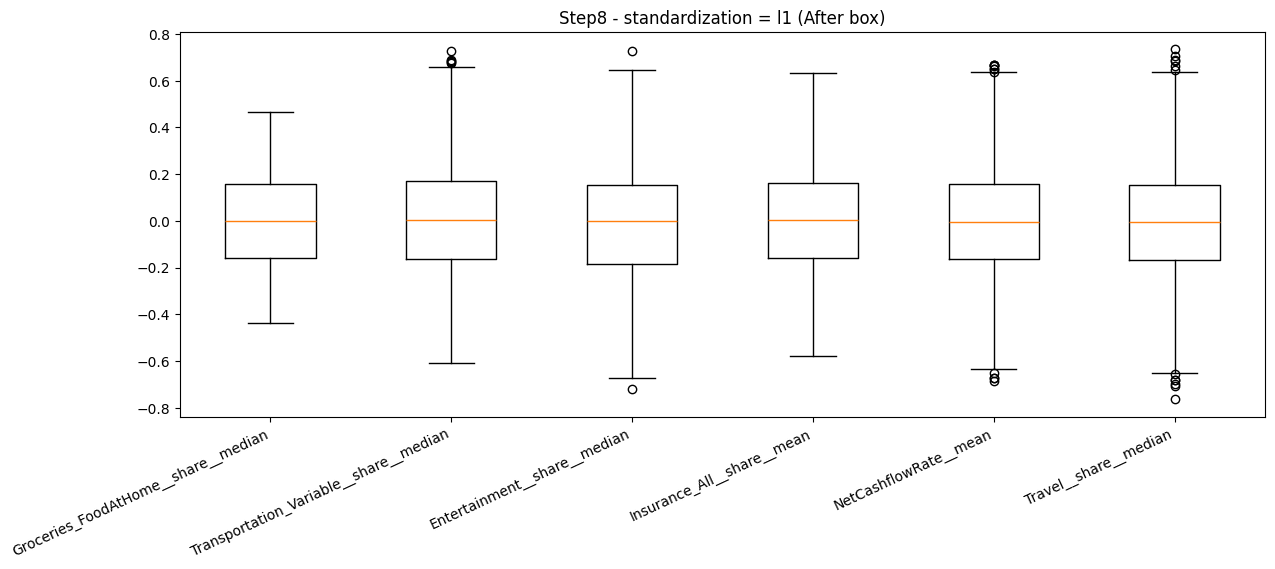

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Step8 summary:


standardization       acc  macro_f1
0            none  0.992125  0.992141
1              l2  0.925000  0.925041
2              l1  0.882625  0.883092


Step8 BEST = none | acc=0.9921 macro_f1=0.9921


In [12]:
# i treat this as row-wise normalization: L1 vs L2 vs none.
# scaling was per-feature above; this is per-row standardization.

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

methods = ["none", "l2", "l1"]
plot_feats = list(X.columns[:6])
X_plot = X[plot_feats].copy()

def apply_row_norm(Xdf, mode):
    if mode == "none":
        return Xdf.copy(), None
    norm = Normalizer(norm=mode)
    Xt = pd.DataFrame(norm.fit_transform(Xdf.values), columns=Xdf.columns, index=Xdf.index)
    return Xt, norm

results = []
best = {"mode": None, "X": None, "mf1": -1, "acc": -1, "obj": None}

pbar = tqdm(methods, desc="Step8 standardization compare")
for m in pbar:
    Xm, obj = apply_row_norm(X, m)
    Xp_after, _ = apply_row_norm(X_plot, m)
    plot_before_after_df(X_plot, Xp_after, f"Step8 - standardization = {m}")

    acc, mf1 = quick_eval_lr(Xm, y, groups, scaler_name="none", penalty_mode=STATE["reg_mode"],
                            C=STATE["reg_params"].get("C",1.0), l1_ratio=STATE["reg_params"].get("l1_ratio",0.5))
    results.append((m, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["mf1"]:
        best.update({"mode": m, "X": Xm, "mf1": mf1, "acc": acc, "obj": obj})

pbar.close()

res_df = pd.DataFrame(results, columns=["standardization","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep8 summary:")
display(res_df)

print(f"\nStep8 BEST = {best['mode']} | acc={best['acc']:.4f} macro_f1={best['mf1']:.4f}")

STATE["standardization_method"] = best["mode"]
STATE["standardization_obj"] = best["obj"]
STATE["X_current"] = best["X"]


Data Sampling (SMOTE, SMOTEENN, and more) with eval and pick best

In [13]:
# NOTE: synthetic clusters should be balanced. so sampling often wont help.
# but still compare none / SMOTE / SMOTEENN / undersample.

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

X = STATE["X_current"].copy()
y = STATE["y"]
groups = STATE["groups"]

# sample only on training split (never touch test)
tr_idx, te_idx = split_by_group(X, y, groups)
Xtr = X.iloc[tr_idx].values
Xte = X.iloc[te_idx].values
ytr = y[tr_idx]
yte = y[te_idx]

samplers = [
    ("none", None),
    ("SMOTE", SMOTE(random_state=RANDOM_SEED)),
    ("SMOTEENN", SMOTEENN(random_state=RANDOM_SEED)),
    ("UnderSample", RandomUnderSampler(random_state=RANDOM_SEED)),
]

results = []
best = {"name": None, "mf1": -1, "acc": -1, "sampler": None, "Xtr": None, "ytr": None}

pbar = tqdm(samplers, desc="Step9 sampling compare")
for name, sampler in pbar:
    if sampler is None:
        Xtr_s, ytr_s = Xtr, ytr
    else:
        Xtr_s, ytr_s = sampler.fit_resample(Xtr, ytr)

    # evaluation model for sampling stage: LR (fast)
    mode = STATE["reg_mode"]
    params = STATE["reg_params"]

    if mode == "elasticnet":
        model = LogisticRegression(multi_class="multinomial", solver="saga", penalty="elasticnet",
                                   l1_ratio=params.get("l1_ratio",0.5), C=params.get("C",1.0),
                                   max_iter=900, n_jobs=-1, random_state=RANDOM_SEED)
    elif mode == "l1":
        model = LogisticRegression(multi_class="multinomial", solver="saga", penalty="l1",
                                   C=params.get("C",1.0), max_iter=900, n_jobs=-1, random_state=RANDOM_SEED)
    else:
        model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=700, n_jobs=-1)

    model.fit(Xtr_s, ytr_s)
    pred = model.predict(Xte)

    acc = accuracy_score(yte, pred)
    mf1 = f1_score(yte, pred, average="macro")
    results.append((name, acc, mf1))
    pbar.set_postfix({"macro_f1": f"{mf1:.3f}", "acc": f"{acc:.3f}"})

    if mf1 > best["mf1"]:
        best.update({"name": name, "mf1": mf1, "acc": acc, "sampler": sampler, "Xtr": Xtr_s, "ytr": ytr_s})

pbar.close()

res_df = pd.DataFrame(results, columns=["sampler","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nStep9 summary:")
display(res_df)

print(f"\nStep9 BEST = {best['name']} | acc={best['acc']:.4f} macro_f1={best['mf1']:.4f}")

STATE["sampling_method"] = best["name"]
STATE["sampler_obj"] = best["sampler"]
STATE["train_split"] = {"tr_idx": tr_idx, "te_idx": te_idx}
STATE["Xtr_final"] = best["Xtr"]
STATE["ytr_final"] = best["ytr"]
STATE["Xte_final"] = Xte
STATE["yte_final"] = yte

Step9 sampling compare:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi


Step9 summary:


sampler       acc  macro_f1
0         none  0.992125  0.992141
1        SMOTE  0.992125  0.992141
3  UnderSample  0.991750  0.991767
2     SMOTEENN  0.963875  0.964034


Step9 BEST = none | acc=0.9921 macro_f1=0.9921


Logistic Regression with progress and eval

Training LogisticRegression:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



LR results: acc=0.9921 macro_f1=0.9921

              precision    recall  f1-score   support

           0      0.995     0.996     0.996      1361
           1      0.988     0.986     0.987      1327
           2      0.986     0.987     0.987      1355
           3      0.992     0.991     0.991      1311
           4      0.993     0.996     0.995      1350
           5      0.999     0.996     0.998      1296

    accuracy                          0.992      8000
   macro avg      0.992     0.992     0.992      8000
weighted avg      0.992     0.992     0.992      8000



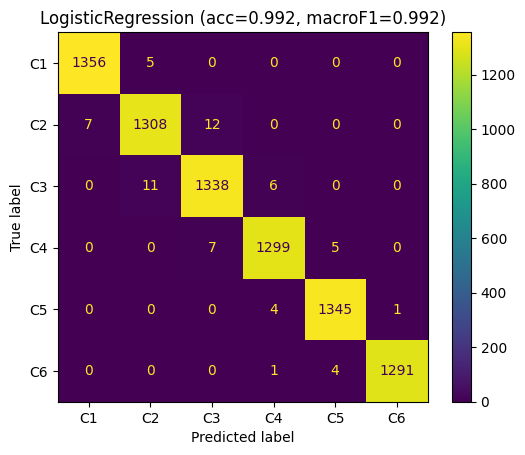

In [14]:
# train using the best preprocessing found and best sampling choice.

Xtr = STATE["Xtr_final"]
ytr = STATE["ytr_final"]
Xte = STATE["Xte_final"]
yte = STATE["yte_final"]

mode = STATE["reg_mode"]
params = STATE["reg_params"]

pbar = tqdm(total=1, desc="Training LogisticRegression")
if mode == "elasticnet":
    lr = LogisticRegression(multi_class="multinomial", solver="saga", penalty="elasticnet",
                            l1_ratio=params.get("l1_ratio",0.5), C=params.get("C",1.0),
                            max_iter=1200, n_jobs=-1, random_state=RANDOM_SEED)
elif mode == "l1":
    lr = LogisticRegression(multi_class="multinomial", solver="saga", penalty="l1",
                            C=params.get("C",1.0), max_iter=1200, n_jobs=-1, random_state=RANDOM_SEED)
else:
    lr = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=900, n_jobs=-1)

lr.fit(Xtr, ytr)
pbar.update(1)
pbar.close()

pred = lr.predict(Xte)
acc = accuracy_score(yte, pred)
mf1 = f1_score(yte, pred, average="macro")

print(f"\nLR results: acc={acc:.4f} macro_f1={mf1:.4f}\n")
print(classification_report(yte, pred, digits=3))

ConfusionMatrixDisplay.from_predictions(yte, pred, display_labels=[f"C{i+1}" for i in range(6)], values_format="d")
plt.title(f"LogisticRegression (acc={acc:.3f}, macroF1={mf1:.3f})")
plt.show()

STATE["model_lr"] = lr
STATE["metrics_lr"] = {"acc": acc, "macro_f1": mf1}

Random Forest and ExtraTrees with progress and eval

Training RandomForest:   0%|          | 0/1 [00:00<?, ?it/s]


RandomForest results: acc=0.9951 macro_f1=0.9951

              precision    recall  f1-score   support

           0      1.000     0.999     0.999      1361
           1      0.989     0.999     0.994      1327
           2      0.990     0.990     0.990      1355
           3      0.996     0.990     0.993      1311
           4      0.996     0.998     0.997      1350
           5      1.000     0.995     0.998      1296

    accuracy                          0.995      8000
   macro avg      0.995     0.995     0.995      8000
weighted avg      0.995     0.995     0.995      8000



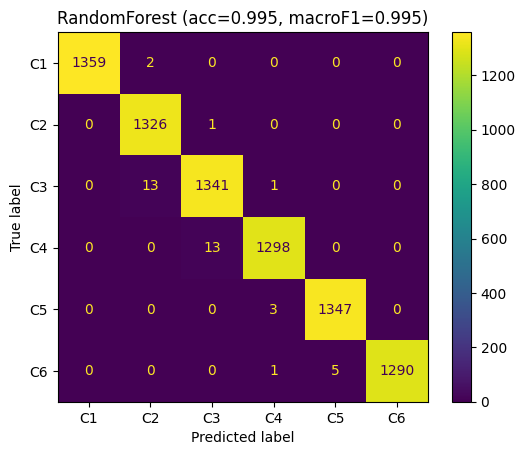

Training ExtraTrees:   0%|          | 0/1 [00:00<?, ?it/s]


ExtraTrees results: acc=0.9930 macro_f1=0.9930

              precision    recall  f1-score   support

           0      0.996     0.985     0.991      1361
           1      0.975     0.995     0.985      1327
           2      0.993     0.990     0.991      1355
           3      0.998     0.993     0.995      1311
           4      0.997     0.998     0.997      1350
           5      1.000     0.998     0.999      1296

    accuracy                          0.993      8000
   macro avg      0.993     0.993     0.993      8000
weighted avg      0.993     0.993     0.993      8000



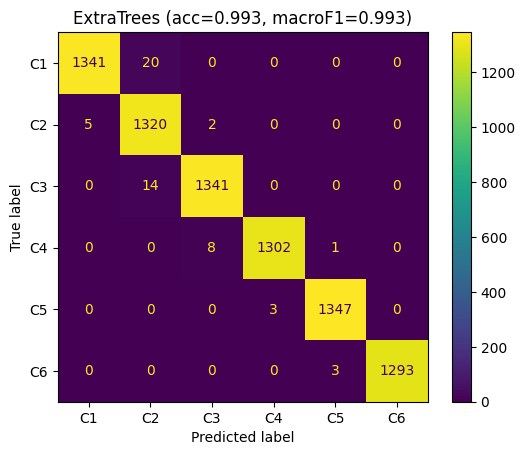

In [15]:
Xtr = STATE["Xtr_final"]
ytr = STATE["ytr_final"]
Xte = STATE["Xte_final"]
yte = STATE["yte_final"]

models = [
    ("RandomForest", RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=RANDOM_SEED)),
    ("ExtraTrees", ExtraTreesClassifier(n_estimators=700, n_jobs=-1, random_state=RANDOM_SEED)),
]

for name, model in models:
    pbar = tqdm(total=1, desc=f"Training {name}")
    model.fit(Xtr, ytr)
    pbar.update(1)
    pbar.close()

    pred = model.predict(Xte)
    acc = accuracy_score(yte, pred)
    mf1 = f1_score(yte, pred, average="macro")

    print(f"\n{name} results: acc={acc:.4f} macro_f1={mf1:.4f}\n")
    print(classification_report(yte, pred, digits=3))

    ConfusionMatrixDisplay.from_predictions(yte, pred, display_labels=[f"C{i+1}" for i in range(6)], values_format="d")
    plt.title(f"{name} (acc={acc:.3f}, macroF1={mf1:.3f})")
    plt.show()

    STATE[f"model_{name.lower()}"] = model
    STATE[f"metrics_{name.lower()}"] = {"acc": acc, "macro_f1": mf1}

XGBoost, MLP, and optional LinearSVC with progress and eval

Training XGBoost:   0%|          | 0/1 [00:00<?, ?it/s]


XGBoost results: acc=0.9958 macro_f1=0.9958

              precision    recall  f1-score   support

           0      0.999     0.998     0.999      1361
           1      0.989     0.997     0.993      1327
           2      0.994     0.989     0.991      1355
           3      0.995     0.996     0.996      1311
           4      0.997     0.998     0.997      1350
           5      1.000     0.997     0.998      1296

    accuracy                          0.996      8000
   macro avg      0.996     0.996     0.996      8000
weighted avg      0.996     0.996     0.996      8000



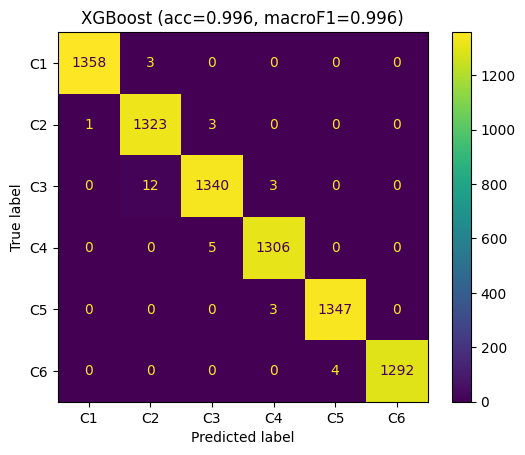

Training MLP:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



MLP results: acc=0.9881 macro_f1=0.9882

              precision    recall  f1-score   support

           0      0.999     0.961     0.980      1361
           1      0.952     0.995     0.973      1327
           2      0.992     0.986     0.989      1355
           3      0.993     0.994     0.994      1311
           4      0.996     0.996     0.996      1350
           5      0.998     0.998     0.998      1296

    accuracy                          0.988      8000
   macro avg      0.988     0.988     0.988      8000
weighted avg      0.988     0.988     0.988      8000



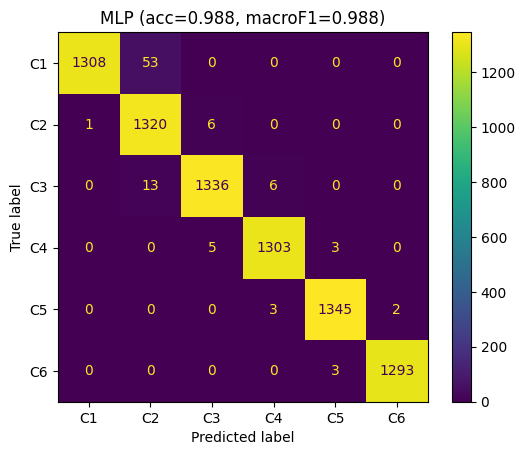

Training LinearSVC:   0%|          | 0/1 [00:00<?, ?it/s]


LinearSVC results: acc=0.8852 macro_f1=0.8854

              precision    recall  f1-score   support

           0      0.987     0.984     0.986      1361
           1      0.843     0.854     0.848      1327
           2      0.810     0.769     0.789      1355
           3      0.806     0.847     0.826      1311
           4      0.874     0.871     0.872      1350
           5      0.994     0.989     0.991      1296

    accuracy                          0.885      8000
   macro avg      0.886     0.886     0.885      8000
weighted avg      0.886     0.885     0.885      8000



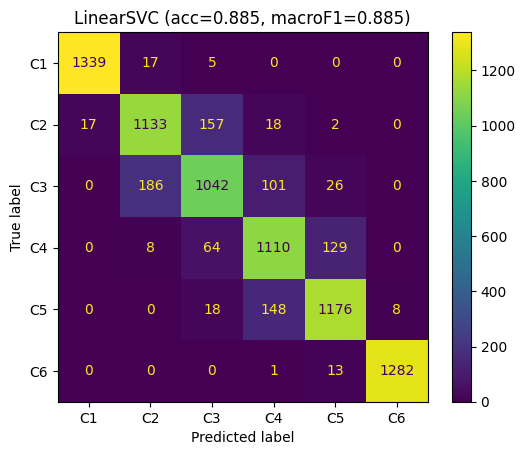

In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

Xtr = STATE["Xtr_final"]
ytr = STATE["ytr_final"]
Xte = STATE["Xte_final"]
yte = STATE["yte_final"]

models = []

# XGBoost
models.append((
    "XGBoost",
    xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=6,
        n_estimators=900,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        tree_method="hist",
        random_state=RANDOM_SEED,
        n_jobs=-1,
        eval_metric="mlogloss"
    )
))

# MLP (small)
models.append((
    "MLP",
    MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=50, random_state=RANDOM_SEED)
))

# Optional SVM (can be slower on big data)
if FAST_MODE:
    models.append((
        "LinearSVC",
        LinearSVC(random_state=RANDOM_SEED)
    ))

for name, model in models:
    pbar = tqdm(total=1, desc=f"Training {name}")
    if name == "XGBoost":
        model.fit(Xtr, ytr, eval_set=[(Xte, yte)], verbose=False)
    else:
        model.fit(Xtr, ytr)
    pbar.update(1)
    pbar.close()

    pred = model.predict(Xte)
    acc = accuracy_score(yte, pred)
    mf1 = f1_score(yte, pred, average="macro")

    print(f"\n{name} results: acc={acc:.4f} macro_f1={mf1:.4f}\n")
    print(classification_report(yte, pred, digits=3))

    ConfusionMatrixDisplay.from_predictions(yte, pred, display_labels=[f"C{i+1}" for i in range(6)], values_format="d")
    plt.title(f"{name} (acc={acc:.3f}, macroF1={mf1:.3f})")
    plt.show()

    STATE[f"model_{name.lower()}"] = model
    STATE[f"metrics_{name.lower()}"] = {"acc": acc, "macro_f1": mf1}

Results & Evaluation to pick the best model and dump pkl for backend

In [17]:
# final: pick best model by macro_f1 and save it with preprocess config.

import joblib

# gather metrics
all_metrics = []
for k, v in STATE.items():
    if k.startswith("metrics_"):
        model_name = k.replace("metrics_", "")
        all_metrics.append((model_name, v["acc"], v["macro_f1"]))

res = pd.DataFrame(all_metrics, columns=["model","acc","macro_f1"]).sort_values("macro_f1", ascending=False)
print("\nFinal model comparison:")
display(res)

best_row = res.iloc[0]
best_name = best_row["model"]
best_model = STATE.get(f"model_{best_name}")

print(f"\nBEST MODEL = {best_name} | acc={best_row['acc']:.4f} macro_f1={best_row['macro_f1']:.4f}")

# save everything needed for backend
os.makedirs("artifacts", exist_ok=True)

joblib.dump(best_model, "artifacts/best_cluster_model.pkl")

# save feature names and pipeline choices so server can reproduce input exactly
with open("artifacts/feature_cols.json", "w") as f:
    json.dump(STATE["feature_cols"], f, indent=2)

with open("artifacts/pipeline_config.json", "w") as f:
    json.dump({
        "norm_method": STATE.get("norm_method"),
        "reg_mode": STATE.get("reg_mode"),
        "reg_params": STATE.get("reg_params"),
        "outlier_method": STATE.get("outlier_method"),
        "feature_select_method": STATE.get("feature_select_method"),
        "scaler_method": STATE.get("scaler_method"),
        "standardization_method": STATE.get("standardization_method"),
        "sampling_method": STATE.get("sampling_method"),
    }, f, indent=2)

# if scaler / normalizer exist we dump them too (so backend uses same objects)
joblib.dump(STATE.get("scaler_obj"), "artifacts/scaler_obj.pkl")
joblib.dump(STATE.get("standardization_obj"), "artifacts/standardization_obj.pkl")
joblib.dump(STATE.get("sampler_obj"), "artifacts/sampler_obj.pkl")

print("\nSaved artifacts:")
!ls -lh artifacts


Final model comparison:


model       acc  macro_f1
3       xgboost  0.995750  0.995760
1  randomforest  0.995125  0.995128
2    extratrees  0.993000  0.993044
0            lr  0.992125  0.992141
4           mlp  0.988125  0.988214
5     linearsvc  0.885250  0.885432


BEST MODEL = xgboost | acc=0.9958 macro_f1=0.9958

Saved artifacts:
total 6.1M
-rw-r--r-- 1 root root 6.0M Jan  1 03:49 best_cluster_model.pkl
-rw-r--r-- 1 root root  911 Jan  1 03:49 feature_cols.json
-rw-r--r-- 1 root root  289 Jan  1 03:49 pipeline_config.json
-rw-r--r-- 1 root root    4 Jan  1 03:49 sampler_obj.pkl
-rw-r--r-- 1 root root    4 Jan  1 03:49 scaler_obj.pkl
-rw-r--r-- 1 root root    4 Jan  1 03:49 standardization_obj.pkl
